In [1]:
import pandas as pd
import seaborn as sns
import scipy.stats as stats
import numpy as np
import matplotlib.pyplot as plt

# IPSP

In [2]:
class  IPSP:
    def __init__(self, t_prior_lower, t_prior_upper, r_prior_lower, r_prior_upper):
      self.t_prior_lower = t_prior_lower
      self.t_prior_upper = t_prior_upper
      self.r_prior_lower = r_prior_lower
      self.r_prior_upper = r_prior_upper
      
      self.t = 0
      self.n = 0


    def execute(self, t, n):
      if (n/t >= self.r_prior_lower):
        self.r_lower = (self.t_prior_upper*self.r_prior_lower+n)/(self.t_prior_upper+t)
      else:
        self.r_lower = (self.t_prior_lower*self.r_prior_lower+n)/(self.t_prior_lower+t)

      if (n/t <= self.r_prior_lower):
        self.r_upper = (self.t_prior_upper*self.r_prior_upper+n)/(self.t_prior_upper+t)
      else:
        self.r_upper = (self.t_prior_lower*self.r_prior_upper+n)/(self.t_prior_lower+t)

      return (self.r_lower, self.r_upper)

In [3]:
def showPlot(dictDF, OPTIONS, t_Lower,t_Upper,r_Lower,r_Upper):
  fig, axes = plt.subplots(1, len(OPTIONS), figsize=(len(OPTIONS)*5,4))#, sharey=True)
  fig.suptitle(r'$t_0=%i, \overline{t_0}=%i,  \lambda_0=%.2f, \overline{\lambda_0}=%.2f$' %(t_Lower,t_Upper,r_Lower,r_Upper), fontsize=13, y=1.03)

  for i in range(0,len(OPTIONS)):
    sns.lineplot(ax=axes[i], data=dictDF[str(OPTIONS[i])])
    axes[i].set_title("λ = " + str(OPTIONS[i]))


  fig.text(0.5, 0.01, 'Time [s]', ha='center', fontsize=13)
  fig.text(0.1, 0.5, '$\lambda$', va='center', rotation='vertical', fontsize=13)

  plt.show()



## Generic IPSP Functions

In [4]:
def IPSPRunner2(OPTIONS, TMAX, r_Lower, r_Upper, GROUND_TRUTH, SEED = 14):
    dictDF = {}

    for o in OPTIONS:

        n    = 0
        t    = 0

        t_Lower = o[0]
        t_Upper = o[1]

        ipsp = IPSP(t_Lower, t_Upper, r_Lower, r_Upper)
        ipsp_lower = []
        ipsp_upper = []
        t_ipsp     = []

        for i in range(1,TMAX):
            while (i > t):
                #print ("Reading ", i, " n:", n, " t:", t)
                n = n + 1
                t = t + stats.expon.rvs(scale=1/GROUND_TRUTH, size=1, random_state=SEED+n)[0]
                #print (n, t)
                v = ipsp.execute(t, n)
                ipsp_lower.append(v[0])
                ipsp_upper.append(v[1])
                t_ipsp.append(t)

        df = pd.DataFrame(list(zip(ipsp_lower, ipsp_upper, t_ipsp)), columns=['Lower', 'Upper', 't'])
        dictDF[str(o)] = df
        print("n:", n, " ", n/TMAX)
    return dictDF

In [5]:
def showIPSPplot(dictDF, OPTIONS, GROUND_TRUTH, palette=['orange', 'blue']):
    fig, axes = plt.subplots(1, len(OPTIONS), figsize=(len(OPTIONS)*5,4), sharey=True)
    fig.suptitle(r'$\lambda_0=%.2f, \overline{\lambda_0}=%.2f, \lambda = %i$' %(r_Lower,r_Upper, GROUND_TRUTH), fontsize=13, y=1.03)

    for i in range(0,len(OPTIONS)):
        sns.lineplot(ax=axes[i], data=pd.melt(dictDF[str(OPTIONS[i])], ['t']), x='t', y='value', hue='variable', palette=palette, linestyle='--')#dashes=[(5, 4),(5,4)])
        axes[i].axhline(y=GROUND_TRUTH, color='red', linestyle='-', linewidth = 1)
        axes[i].set_title(r'$t_0=%i, \overline{t_0}=%i $' % (OPTIONS[i][0], OPTIONS[i][1]))

    fig.text(0.5, 0.01, 'Time [s]', ha='center', fontsize=13)
    fig.text(0.1, 0.5, '$\lambda$', va='center', rotation='vertical', fontsize=13)

    plt.show()

In [6]:
def IPSPRunnerMultipleGT(TMAX, r_Lower_OPTIONS, r_Upper_OPTIONS, t_lower, t_upper, GROUND_TRUTH_OPTIONS,SEED = 14):
    dictDF = {}

    j = -1
    for o in GROUND_TRUTH_OPTIONS:
        j = j+1
        
        GROUND_TRUTH = o
        r_Lower = r_Lower_OPTIONS[j]
        r_Upper = r_Upper_OPTIONS[j]
        
#         print (GROUND_TRUTH, r_Lower, r_Upper, t_lower, t_Upper)
        
        n    = 0
        t    = 0

        ipsp = IPSP(t_Lower, t_Upper, r_Lower, r_Upper)
        ipsp_lower = []
        ipsp_upper = []
        t_ipsp     = []

        for i in range(1,TMAX):
            while (i > t):
                n = n + 1
                t = t + stats.expon.rvs(scale=1/GROUND_TRUTH, size=1, random_state=SEED+n)[0]
                v = ipsp.execute(t, n)
                ipsp_lower.append(v[0])
                ipsp_upper.append(v[1])
                t_ipsp.append(t)

        df = pd.DataFrame(list(zip(ipsp_lower, ipsp_upper, t_ipsp)), columns=['Lower', 'Upper', 't'])
        dictDF[str(o)] = df
        print("n:", n, " ", n/TMAX)
    return dictDF

In [7]:
def showIPSPplotMultipleGT(dictDF, GROUND_TRUTH_OPTIONS, palette=['orange', 'blue']):
    fig, axes = plt.subplots(1, len(GROUND_TRUTH_OPTIONS), figsize=(len(GROUND_TRUTH_OPTIONS)*5,4), sharey=False)
#     fig.suptitle(r'$\lambda_0=%.2f, \overline{\lambda_0}=%.2f, \lambda = %i$' %(r_Lower,r_Upper, GROUND_TRUTH), fontsize=13, y=1.03)

    for i in range(0,len(GROUND_TRUTH_OPTIONS)):
        sns.lineplot(ax=axes[i], data=pd.melt(dictDF[str(GROUND_TRUTH_OPTIONS[i])], ['t']), x='t', y='value', hue='variable', palette=palette, linestyle='--')#dashes=[(5, 4),(5,4)])
        axes[i].axhline(y=GROUND_TRUTH_OPTIONS[i], color='red', linestyle='-', linewidth = 1)#marker='o',
        axes[i].set_title(r'$\lambda=%.2f$' % (GROUND_TRUTH_OPTIONS[i]))

    fig.text(0.5, 0.01, 'Time [s]', ha='center', fontsize=13)
    fig.text(0.1, 0.5, '$\lambda$', va='center', rotation='vertical', fontsize=13)

    plt.show()

In [8]:
def showIPSPplotWideNarrow(GROUND_TRUTH, OPTIONS, dictDFNarrow, dictDFWide, filename):
    
    fig, axes = plt.subplots(1, len(OPTIONS), figsize=(len(OPTIONS)*5,4), sharey=True)

    for i in range(0,len(OPTIONS)):
        sns.lineplot(ax=axes[i], data=pd.melt(dictDFNarrow[str(OPTIONS[i])], ['t']), x='t', y='value', 
                     hue='variable', palette=['blue', 'blue'], linestyle=(0,(1,1)), linewidth=2)
        sns.lineplot(ax=axes[i], data=pd.melt(dictDFWide[str(OPTIONS[i])], ['t']), x='t', y='value', 
                     hue='variable', palette=['green', 'green'], linestyle=(0, (8, 10)))#dashes=[(1, 3), (1, 3)])#

        #Add horizontal line
        axes[i].axhline(y=GROUND_TRUTH, color='red', linestyle='-', linewidth = 1)#marker='o',

        #Set title
#         axes[i].set_title(r'$t_0=%i, \overline{t_0}=%i $' % (OPTIONS[i][0], OPTIONS[i][1]))  

        #Remove legend
        axes[i].get_legend().remove() 

        #Remove y axis
        axes[i].set(xlabel=None)
        axes[i].set(ylabel=None)
        
        axes[i].yaxis.set_tick_params(labelsize = 14)
        axes[i].xaxis.set_tick_params(labelsize = 14)

        plt.subplots_adjust(hspace=0.001, wspace=0.15)


#     fig.text(0.5, 0.01, 'Time [s]', ha='center', fontsize=13)
    fig.text(0.1, 0.5, '$\lambda$', va='center', rotation='vertical', fontsize=15)


    plt.savefig(filename,dpi=300)

    plt.show()

## Ground truth varies {0.03, 0.3, 3, 30} 
## NARROW impresice prior knowledge bound


n: 320   0.032
n: 3070   0.307
n: 29737   2.9737
n: 299426   29.9426


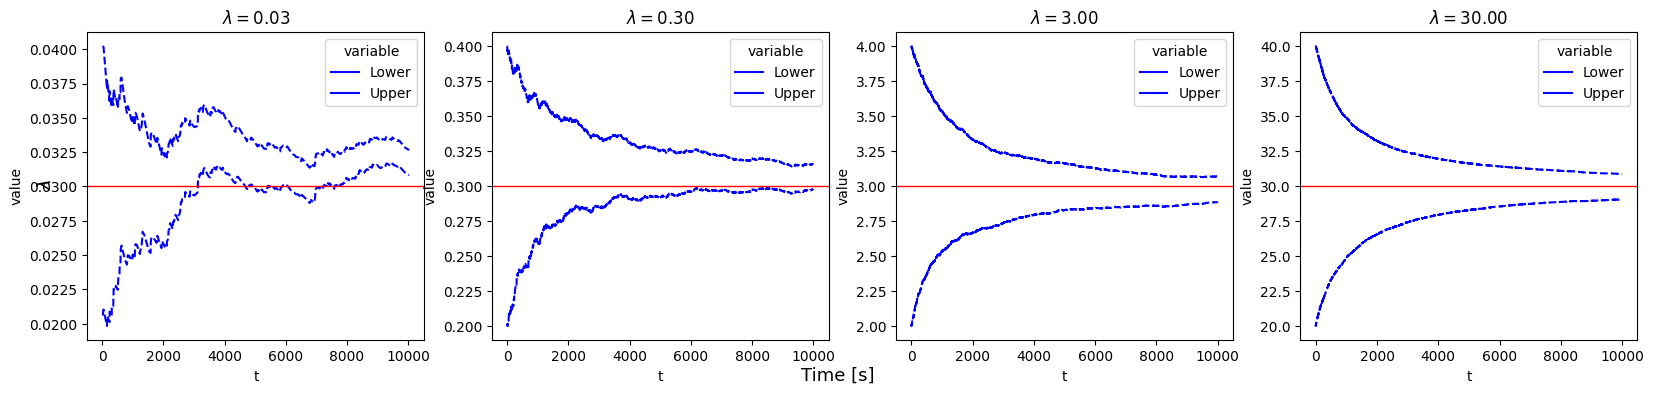

In [9]:

GROUND_TRUTH_OPTIONS = (0.03, 0.3, 3, 30)
TMAX = 10000

r_Lower_OPTIONS = (0.02, 0.2, 2, 20)
r_Upper_OPTIONS = (0.04, 0.4, 4, 40)
t_Lower = 1000
t_Upper = 1000

SEED = 1

dictDFNarrowMultipleGT = IPSPRunnerMultipleGT(TMAX, r_Lower_OPTIONS, r_Upper_OPTIONS, t_Lower, t_Upper, GROUND_TRUTH_OPTIONS, SEED)

showIPSPplotMultipleGT(dictDFNarrowMultipleGT, GROUND_TRUTH_OPTIONS, palette=['b', 'b'])

## Ground truth varies {0.03, 0.3, 3, 30} 
## WIDE impresice prior knowledge bound

n: 317   0.0317
n: 3076   0.3076
n: 29735   2.9735
n: 299425   29.9425


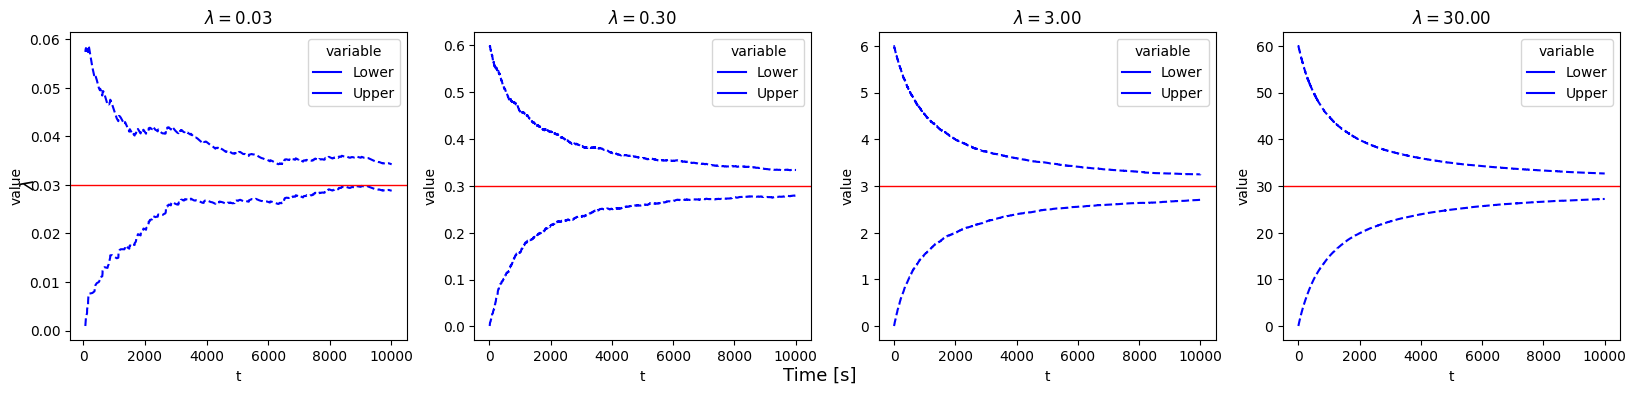

In [10]:

GROUND_TRUTH_OPTIONS = (0.03, 0.3, 3, 30)
TMAX = 10000

r_Lower_OPTIONS = (0.00, 0.0, 0, 0)
r_Upper_OPTIONS = (0.06, 0.6, 6, 60)
t_Lower = 1000
t_Upper = 1000

SEED = 1

dictDFWideMultipleGT = IPSPRunnerMultipleGT(TMAX, r_Lower_OPTIONS, r_Upper_OPTIONS, t_Lower, t_Upper, GROUND_TRUTH_OPTIONS)

showIPSPplotMultipleGT(dictDFWideMultipleGT, GROUND_TRUTH_OPTIONS, palette=['b', 'b'])

## Printing both together

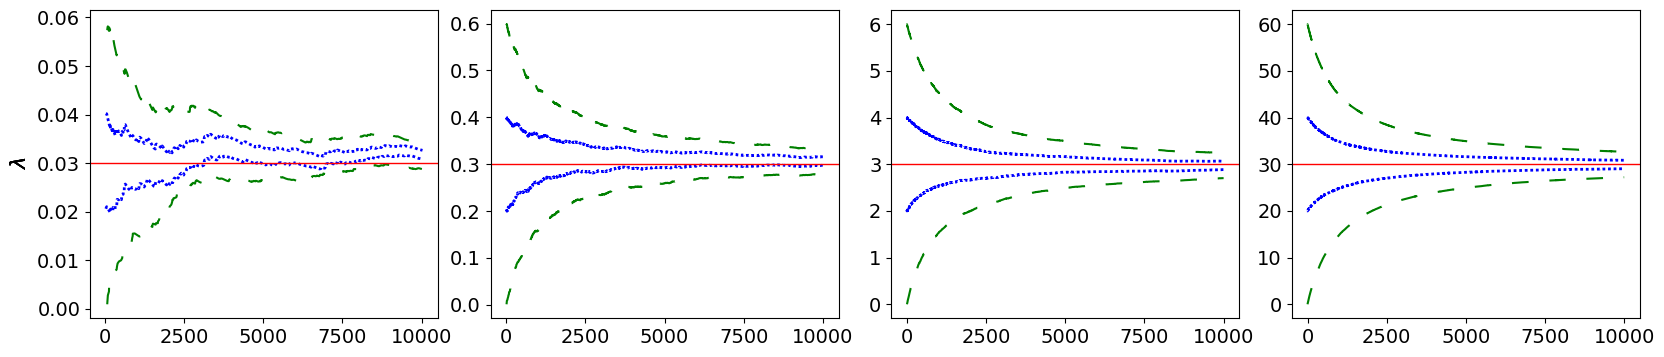

In [11]:

fig, axes = plt.subplots(1, len(GROUND_TRUTH_OPTIONS), figsize=(len(GROUND_TRUTH_OPTIONS)*5,4), sharey=False)

for i in range(0,len(GROUND_TRUTH_OPTIONS)):
    v = GROUND_TRUTH_OPTIONS[i]
    
    sns.lineplot(ax=axes[i], data=pd.melt(dictDFNarrowMultipleGT[str(v)], ['t']), x='t', y='value', 
                 hue='variable', palette=['blue', 'blue'], linestyle=(0,(1,1)), linewidth=2)
    sns.lineplot(ax=axes[i], data=pd.melt(dictDFWideMultipleGT[str(v)], ['t']), x='t', y='value', 
                 hue='variable', palette=['green', 'green'], linestyle=(0, (8, 10)))#dashes=[(1, 3), (1, 3)])#

    #Add horizontal line
    axes[i].axhline(y=v, color='red', linestyle='-', linewidth = 1)#marker='o',

    #Set title
#     axes[i].set_title(r'$\lambda=%.2f$' % (v))

    #Remove legend
    axes[i].get_legend().remove() 

    #Remove y axis
    axes[i].set(xlabel=None)
    axes[i].set(ylabel=None)
    
    #Set tick size of both axis
    axes[i].yaxis.set_tick_params(labelsize = 14)
    axes[i].xaxis.set_tick_params(labelsize = 14)

    #Adjust horizontal space of plots
    plt.subplots_adjust(hspace=0.001, wspace=0.15)


#     fig.text(0.5, 0.01, 'Time [s]', ha='center', fontsize=13)
    fig.text(0.085, 0.5, '$\lambda$', va='center', rotation='vertical', fontsize=15)


plt.savefig('IPSPvariousLambda.pdf',dpi=300)

plt.show()

--- ---
---
---

## Correct Narrow Prior, λ=3,  Increasing confidence t 

n: 29737   2.9737
n: 29737   2.9737
n: 29737   2.9737
n: 29737   2.9737


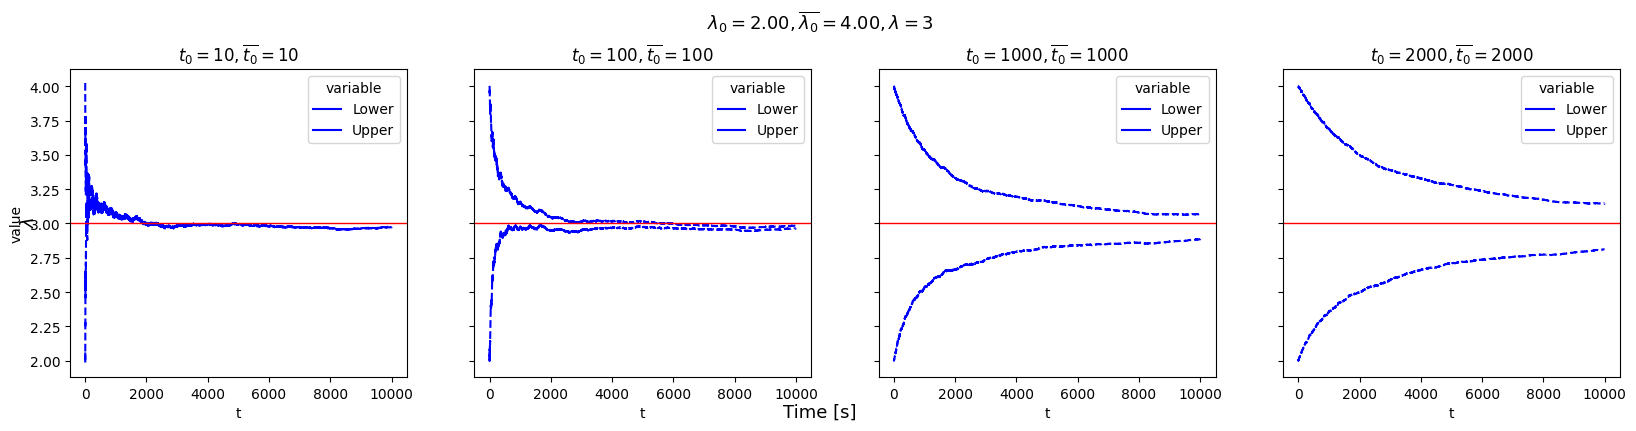

In [12]:

OPTIONS = ((10,10), (100,100), (1000,1000), (2000,2000))#, (5000,5000))
TMAX = 10000

r_Lower = 2
r_Upper = 4

GROUND_TRUTH = 3

dictDFNarrow = IPSPRunner2(OPTIONS, TMAX, r_Lower, r_Upper, GROUND_TRUTH, SEED=1)

showIPSPplot(dictDFNarrow, OPTIONS, GROUND_TRUTH, palette=['b', 'b'])

## Correct Wide Prior, λ=3,  Increasing confidence t 

n: 29737   2.9737
n: 29737   2.9737
n: 29737   2.9737
n: 29737   2.9737


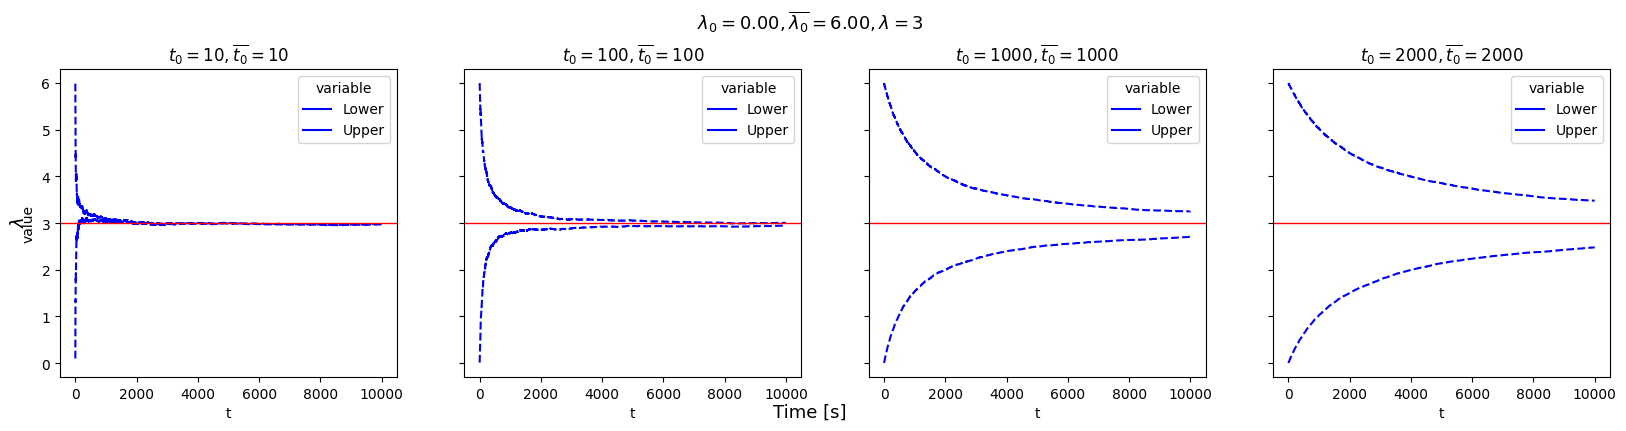

In [13]:

OPTIONS = ((10,10), (100,100), (1000,1000), (2000,2000))#, (5000,5000))
TMAX = 10000

r_Lower = 0
r_Upper = 6

GROUND_TRUTH = 3


dictDFWide = IPSPRunner2(OPTIONS, TMAX, r_Lower, r_Upper, GROUND_TRUTH, SEED=1)

showIPSPplot(dictDFWide, OPTIONS, GROUND_TRUTH, palette=['b', 'b'])


## Correct Prior, Both Narrow and Wide, λ=3,  Increasing confidence t 

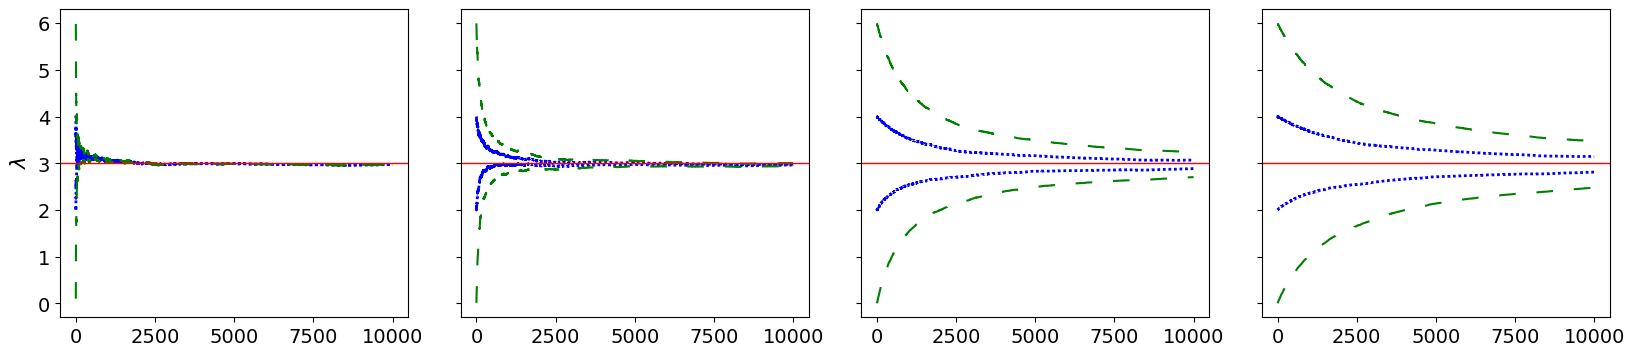

In [14]:

GROUND_TRUTH = 3

showIPSPplotWideNarrow(GROUND_TRUTH, OPTIONS, dictDFNarrow, dictDFWide, 'IPSPCorrect3.pdf')

n: 29737   2.9737
n: 29737   2.9737
n: 29737   2.9737
n: 29737   2.9737


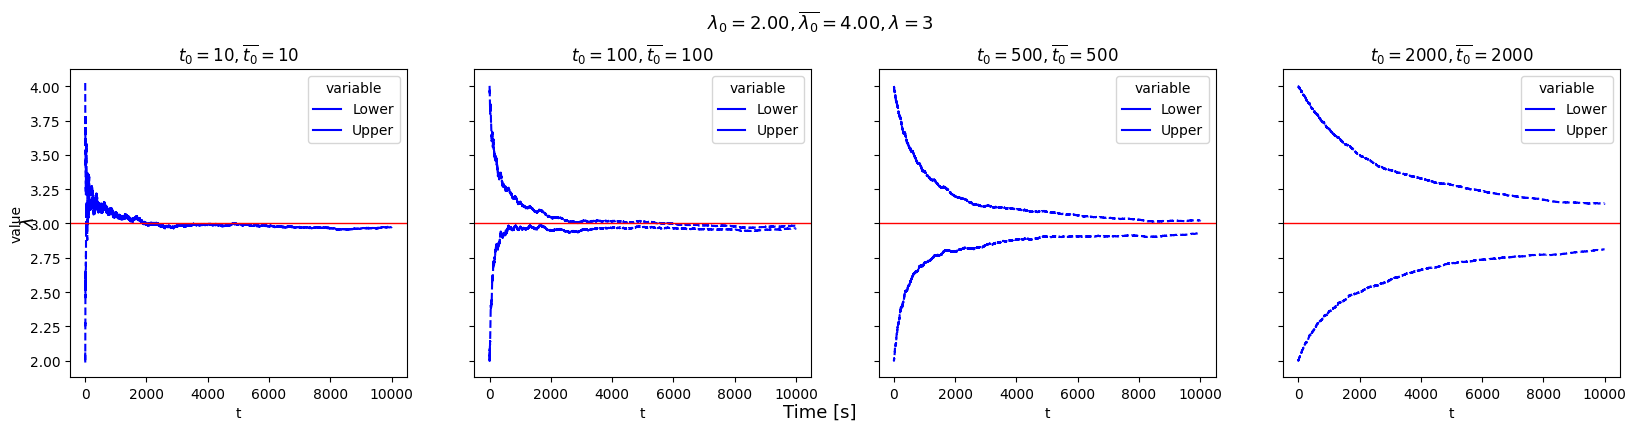

In [15]:

OPTIONS = ((10,10), (100,100), (500,500), (2000,2000))#, (5000,5000))
TMAX = 10000

r_Lower = 2
r_Upper = 4

GROUND_TRUTH = 3

dictDFNarrow = IPSPRunner2(OPTIONS, TMAX, r_Lower, r_Upper, GROUND_TRUTH, SEED=1)

showIPSPplot(dictDFNarrow, OPTIONS, GROUND_TRUTH, palette=['b', 'b'])

n: 29737   2.9737
n: 29737   2.9737
n: 29737   2.9737
n: 29737   2.9737


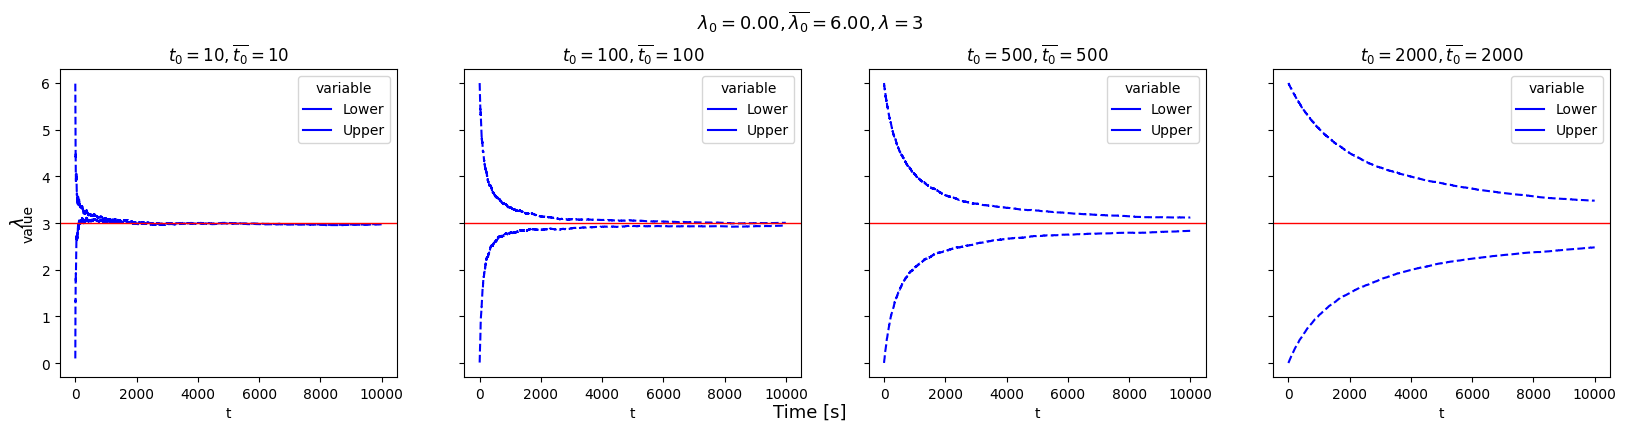

In [16]:

OPTIONS = ((10,10), (100,100), (500,500), (2000,2000))#, (5000,5000))
TMAX = 10000

r_Lower = 0
r_Upper = 6

GROUND_TRUTH = 3


dictDFWide = IPSPRunner2(OPTIONS, TMAX, r_Lower, r_Upper, GROUND_TRUTH, SEED=1)

showIPSPplot(dictDFWide, OPTIONS, GROUND_TRUTH, palette=['b', 'b'])


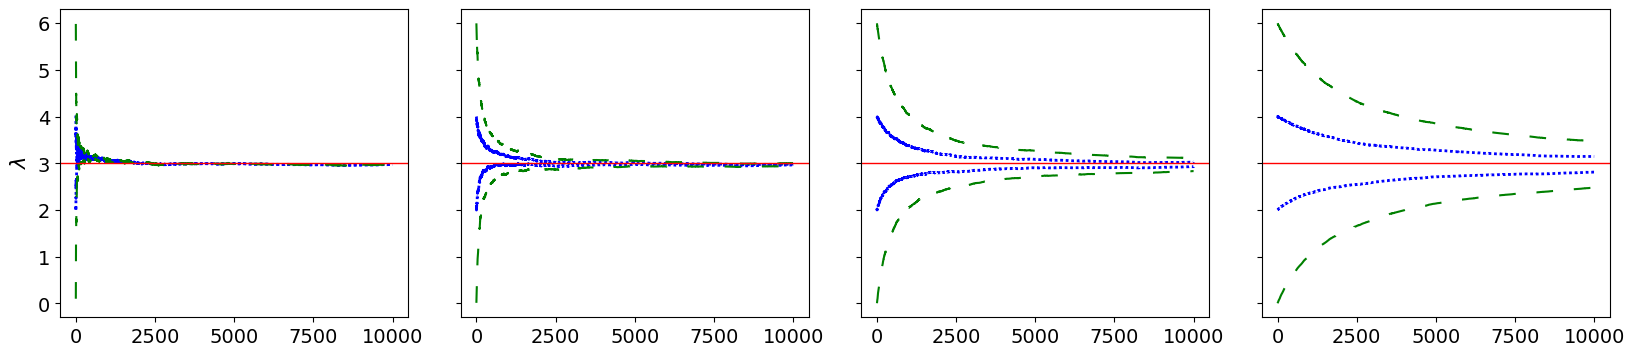

In [17]:

GROUND_TRUTH = 3

showIPSPplotWideNarrow(GROUND_TRUTH, OPTIONS, dictDFNarrow, dictDFWide, 'IPSPCorrect3.pdf')

## Correct Narrow Prior, λ=0.3,  Increasing confidence t 

n: 3070   0.307
n: 3070   0.307
n: 3070   0.307
n: 3070   0.307


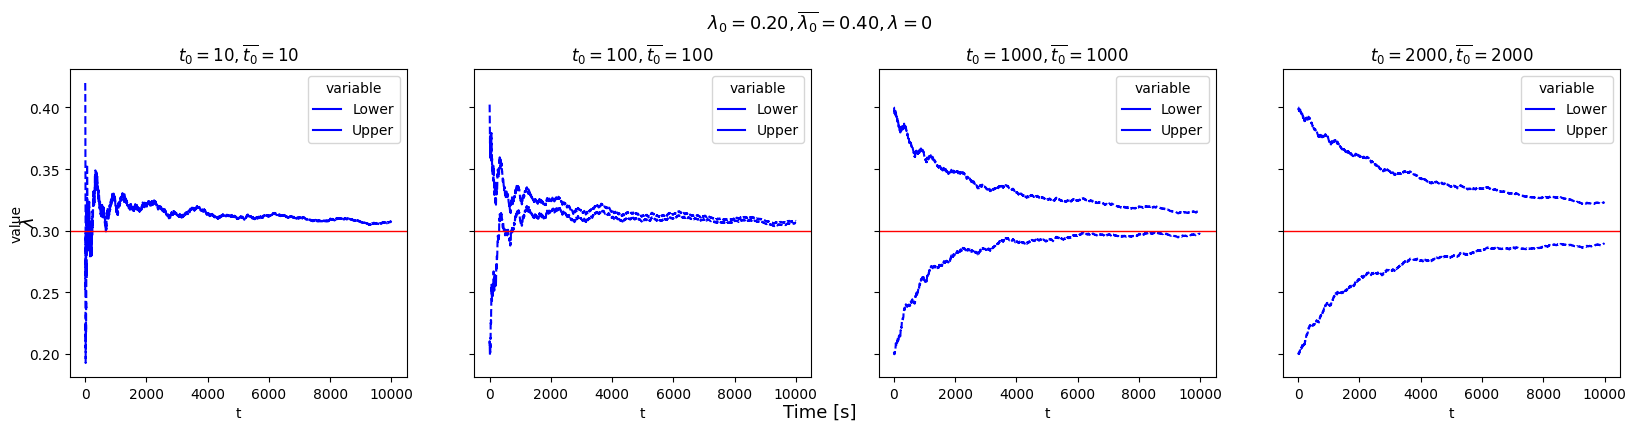

In [18]:

OPTIONS = ((10,10), (100,100), (1000,1000), (2000,2000))#, (5000,5000))
TMAX = 10000

r_Lower = 0.2
r_Upper = 0.4

GROUND_TRUTH = 0.3

dictDFNarrow2 = IPSPRunner2(OPTIONS, TMAX, r_Lower, r_Upper, GROUND_TRUTH, SEED=1)

showIPSPplot(dictDFNarrow2, OPTIONS, GROUND_TRUTH, palette=['b', 'b'])

## Correct Wide Prior, λ=0.3,  Increasing confidence t 

n: 3070   0.307
n: 3070   0.307
n: 3070   0.307
n: 3070   0.307


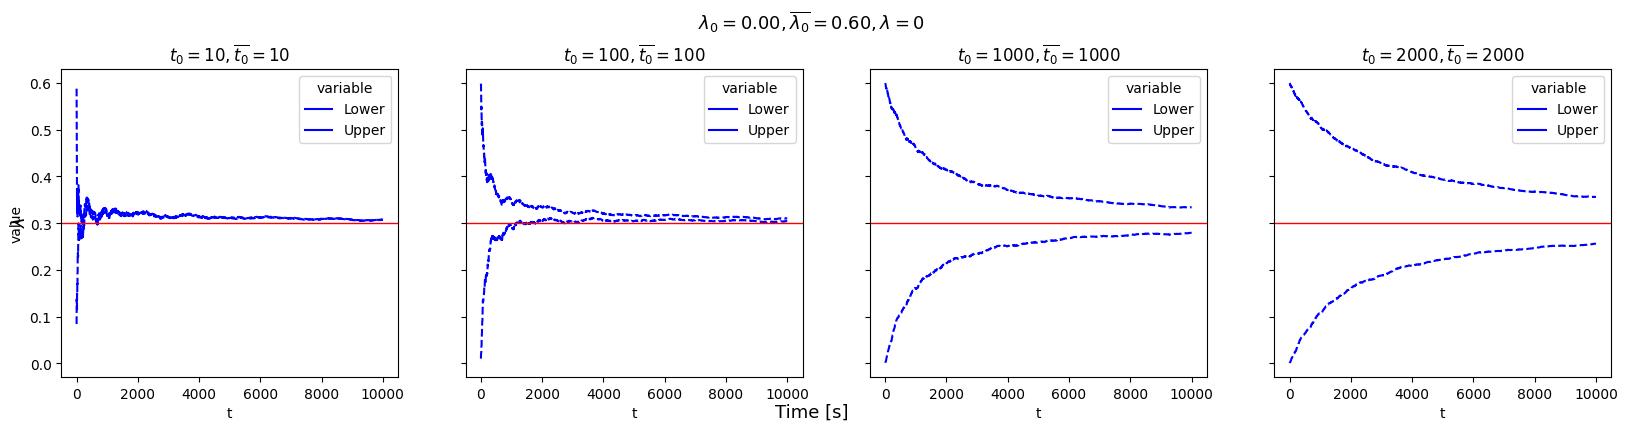

In [19]:

OPTIONS = ((10,10), (100,100), (1000,1000), (2000,2000))#, (5000,5000))
TMAX = 10000

r_Lower = 0.0
r_Upper = 0.6

GROUND_TRUTH = 0.3


dictDFWide2 = IPSPRunner2(OPTIONS, TMAX, r_Lower, r_Upper, GROUND_TRUTH, SEED=1)

showIPSPplot(dictDFWide2, OPTIONS, GROUND_TRUTH, palette=['b', 'b'])


## Correct Prior, Both Narrow and Wide, λ=0.3,  Increasing confidence t 

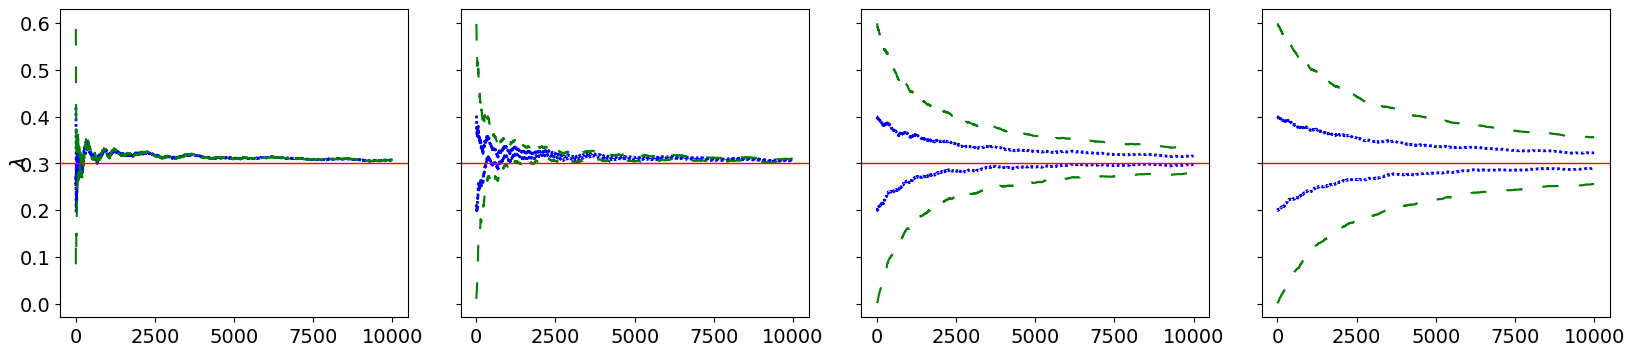

In [20]:

GROUND_TRUTH = 0.3

showIPSPplotWideNarrow(GROUND_TRUTH, OPTIONS, dictDFNarrow2, dictDFWide2, 'IPSPCorrect03.pdf')

--- ---
--- ---
--- ---

## Overapproximate Narrow Prior, λ=3,  Increasing confidence t 

n: 29737   2.9737
n: 29737   2.9737
n: 29737   2.9737
n: 29737   2.9737


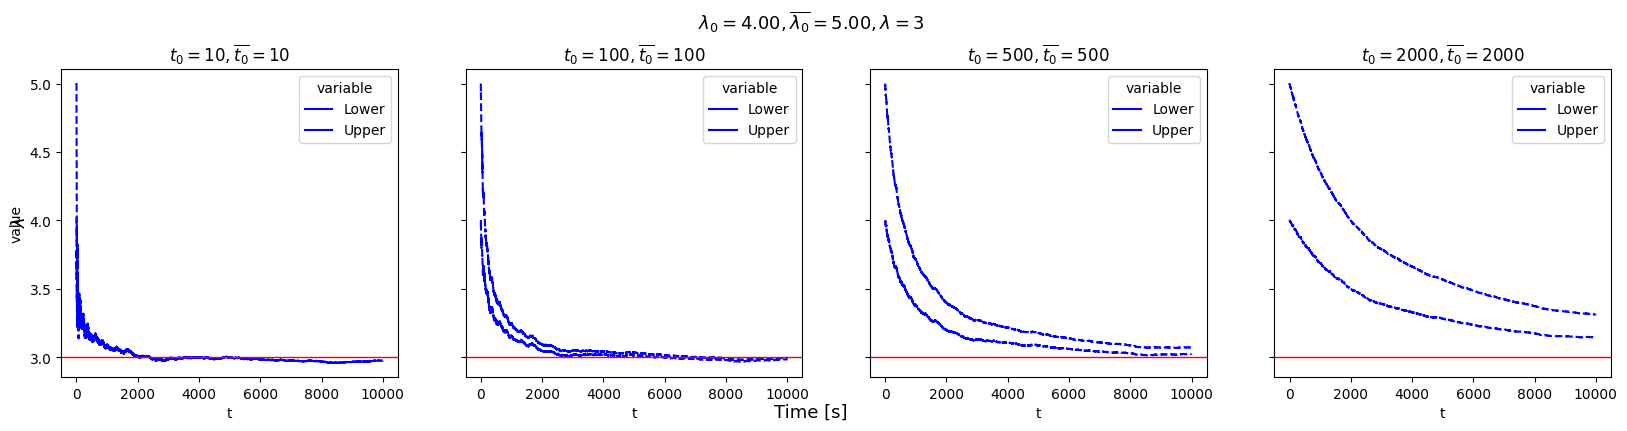

In [21]:

OPTIONS = ((10,10), (100,100), (500,500), (2000,2000))#, (5000,5000))
TMAX = 10000

r_Lower = 4
r_Upper = 5

GROUND_TRUTH = 3


dictDFNarrowDisagree45 = IPSPRunner2(OPTIONS, TMAX, r_Lower, r_Upper, GROUND_TRUTH, SEED=1)

showIPSPplot(dictDFNarrowDisagree45, OPTIONS, GROUND_TRUTH, palette=['b', 'b'])


## Overapproximate Wide Prior, λ=3,  Increasing confidence t 

n: 29737   2.9737
n: 29737   2.9737
n: 29737   2.9737
n: 29737   2.9737


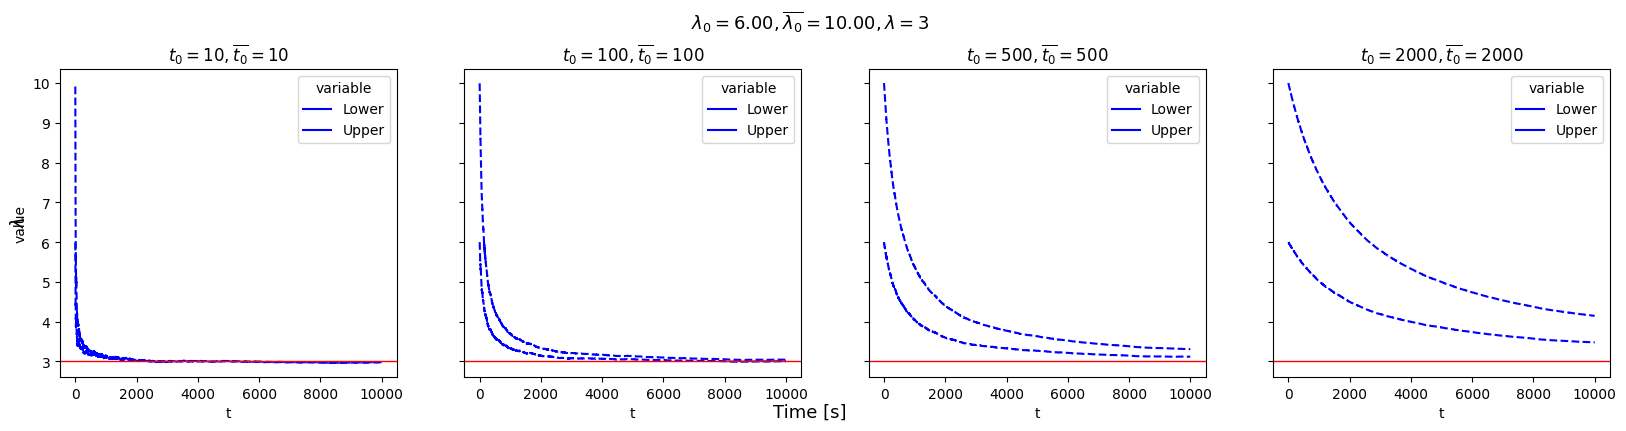

In [22]:

OPTIONS = ((10,10), (100,100), (500,500), (2000,2000))#, (5000,5000))
TMAX = 10000

r_Lower = 6
r_Upper = 10

GROUND_TRUTH = 3


dictDFWideDisagree610 = IPSPRunner2(OPTIONS, TMAX, r_Lower, r_Upper, GROUND_TRUTH, SEED=1)

showIPSPplot(dictDFWideDisagree610, OPTIONS, GROUND_TRUTH, palette=['b', 'b'])


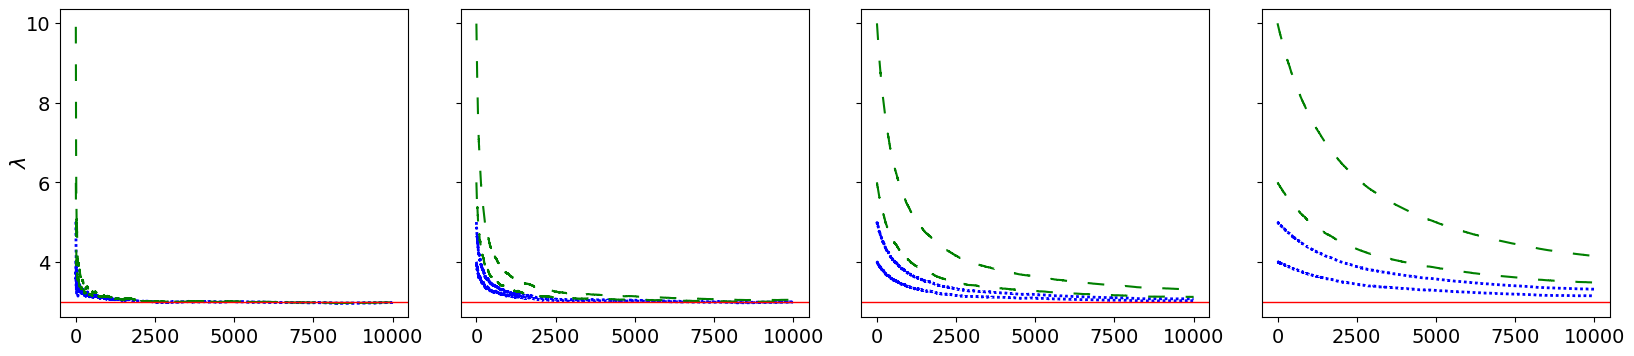

In [23]:

GROUND_TRUTH = 3

showIPSPplotWideNarrow(GROUND_TRUTH, OPTIONS, dictDFNarrowDisagree45, dictDFWideDisagree610, 'IPSPDisagree3A.pdf')


## Underapproximate Narrow Prior, λ=3,  Increasing confidence t 

n: 29737   2.9737
n: 29737   2.9737
n: 29737   2.9737
n: 29737   2.9737


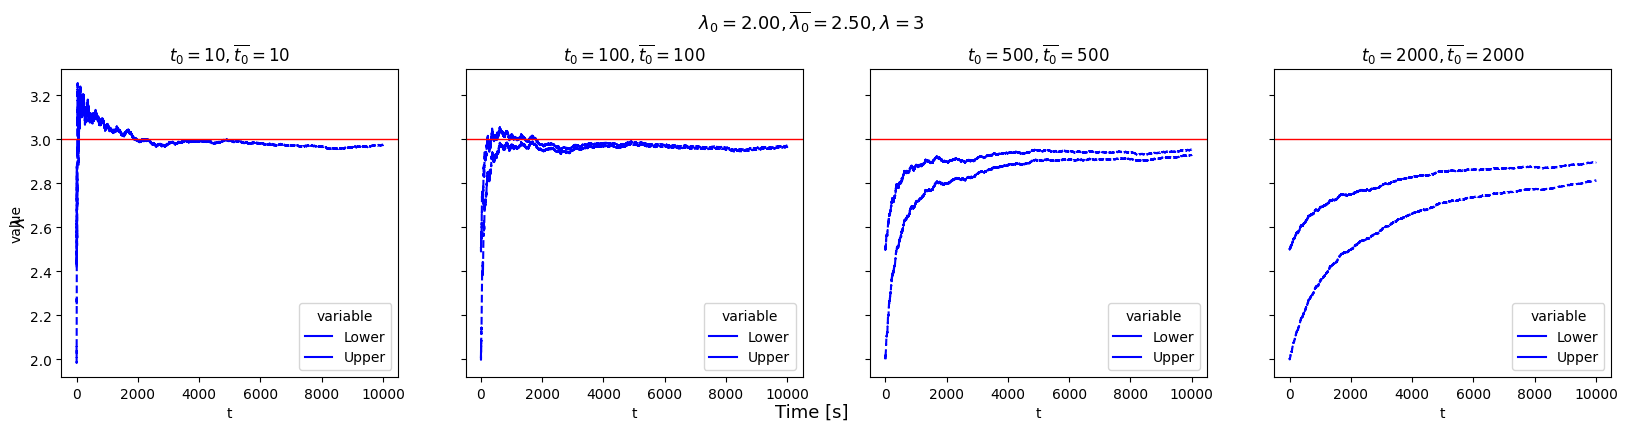

In [24]:

OPTIONS = ((10,10), (100,100), (500,500), (2000,2000))#, (5000,5000))
TMAX = 10000

r_Lower = 2
r_Upper = 2.5

GROUND_TRUTH = 3


dictDFNarrowDisagree12 = IPSPRunner2(OPTIONS, TMAX, r_Lower, r_Upper, GROUND_TRUTH, SEED=1)

showIPSPplot(dictDFNarrowDisagree12, OPTIONS, GROUND_TRUTH, palette=['b', 'b'])


## Underapproximate Wide Prior, λ=3,  Increasing confidence t 

n: 29737   2.9737
n: 29737   2.9737
n: 29737   2.9737
n: 29737   2.9737


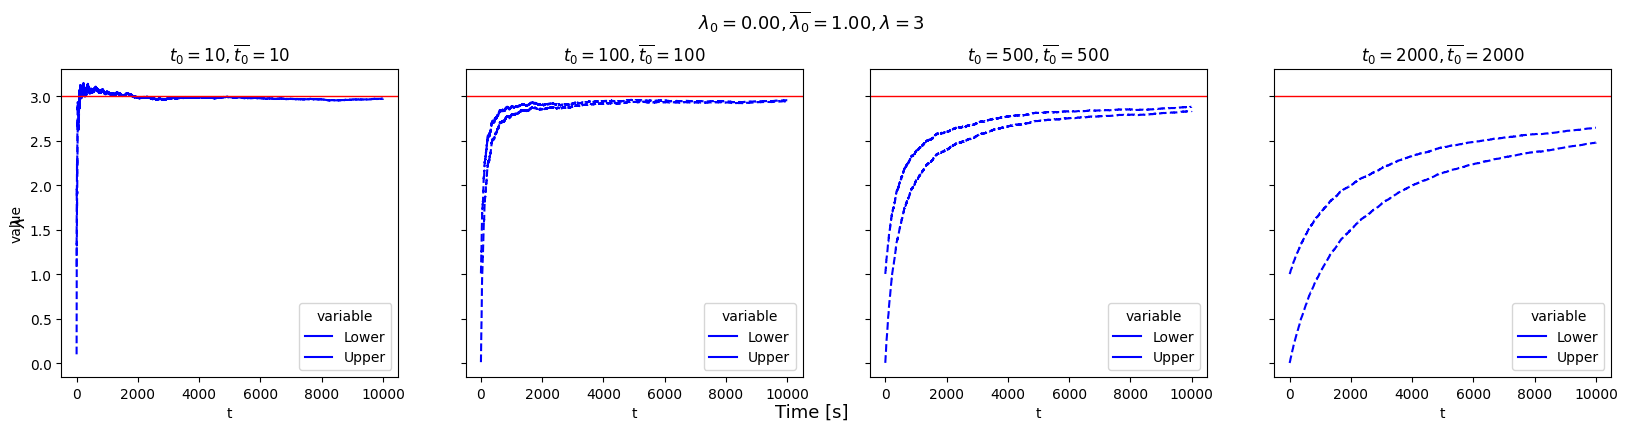

In [25]:

OPTIONS = ((10,10), (100,100), (500,500), (2000,2000))#, (5000,5000))
TMAX = 10000

r_Lower = 0
r_Upper = 1

GROUND_TRUTH = 3


dictDFWideDisagree01 = IPSPRunner2(OPTIONS, TMAX, r_Lower, r_Upper, GROUND_TRUTH, SEED=1)

showIPSPplot(dictDFWideDisagree01, OPTIONS, GROUND_TRUTH, palette=['b', 'b'])


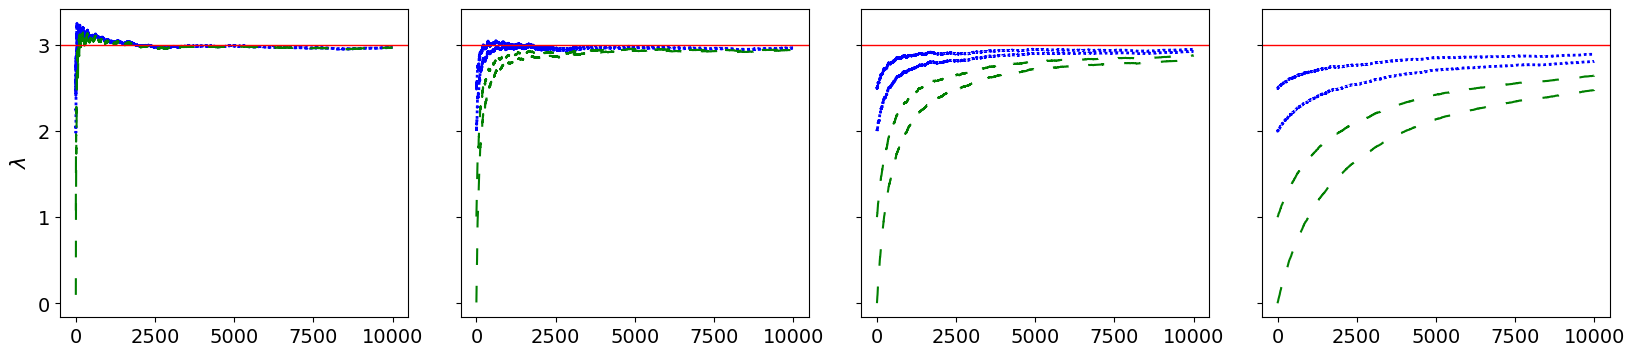

In [26]:

GROUND_TRUTH = 3

showIPSPplotWideNarrow(GROUND_TRUTH, OPTIONS, dictDFNarrowDisagree12, dictDFWideDisagree01, 'IPSPDisagree3B.pdf')


## Incorrect Narrow Prior, λ=1/3,  Increasing confidence t 

n: 3070   0.307
n: 3070   0.307
n: 3070   0.307
n: 3070   0.307
n: 3070   0.307


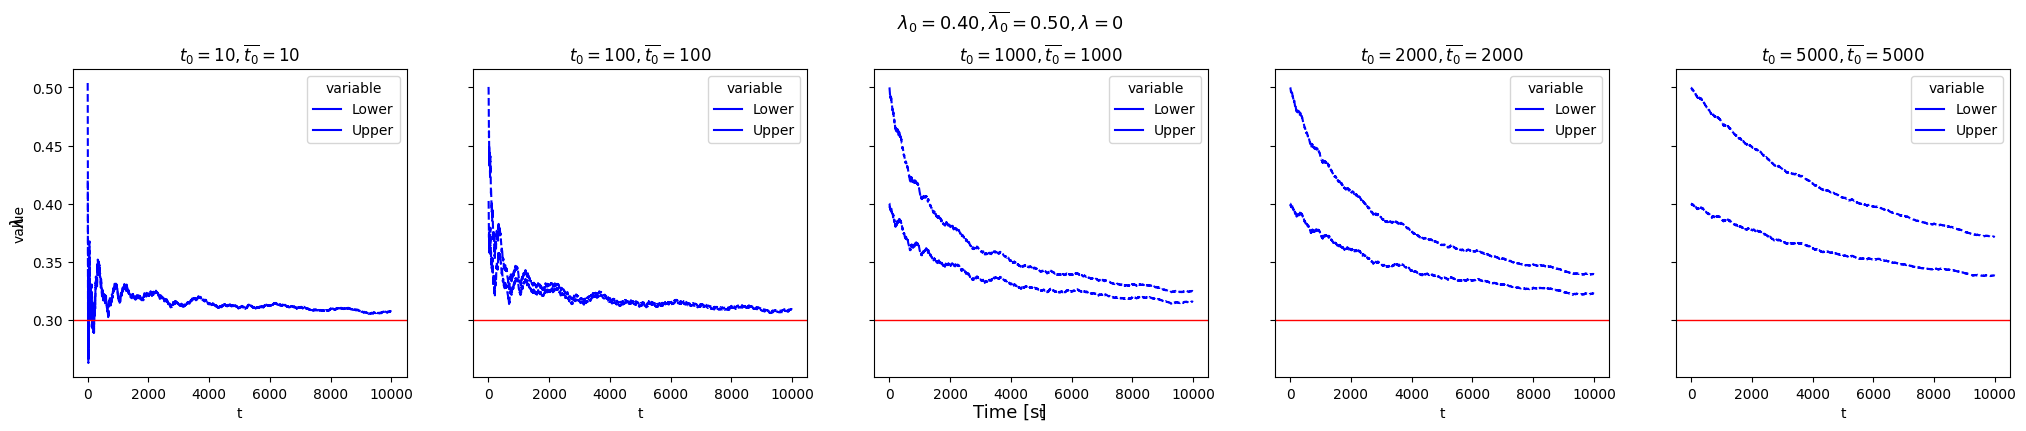

In [27]:

OPTIONS = ((10,10), (100,100), (1000,1000), (2000,2000), (5000,5000))
TMAX = 10000

r_Lower = 0.4
r_Upper = 0.5

GROUND_TRUTH = 0.3


dictDFNarrowDisagree45b= IPSPRunner2(OPTIONS, TMAX, r_Lower, r_Upper, GROUND_TRUTH, SEED=1)

showIPSPplot(dictDFNarrowDisagree45b, OPTIONS, GROUND_TRUTH, palette=['b', 'b'])


## Incorrect Narrow Prior, λ=1/3,  Increasing confidence t 

n: 3070   0.307
n: 3070   0.307
n: 3070   0.307
n: 3070   0.307
n: 3070   0.307


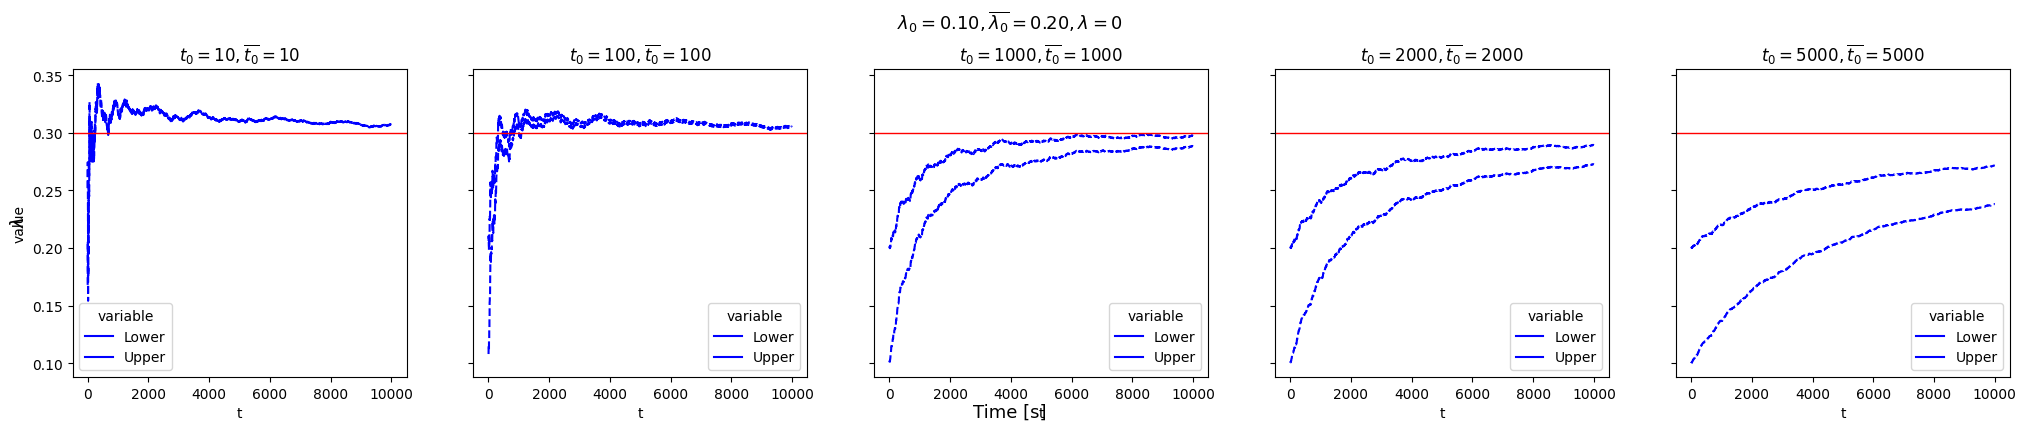

In [28]:

OPTIONS = ((10,10), (100,100), (1000,1000), (2000,2000), (5000,5000))
TMAX = 10000

r_Lower = 0.1
r_Upper = 0.2

GROUND_TRUTH = 0.3


dictDFNarrowDisagree12b= IPSPRunner2(OPTIONS, TMAX, r_Lower, r_Upper, GROUND_TRUTH, SEED=1)

showIPSPplot(dictDFNarrowDisagree12b, OPTIONS, GROUND_TRUTH, palette=['b', 'b'])


## Incorrect Wide Prior, λ=0.3,  Increasing confidence t 

n: 3070   0.307
n: 3070   0.307
n: 3070   0.307
n: 3070   0.307
n: 3070   0.307


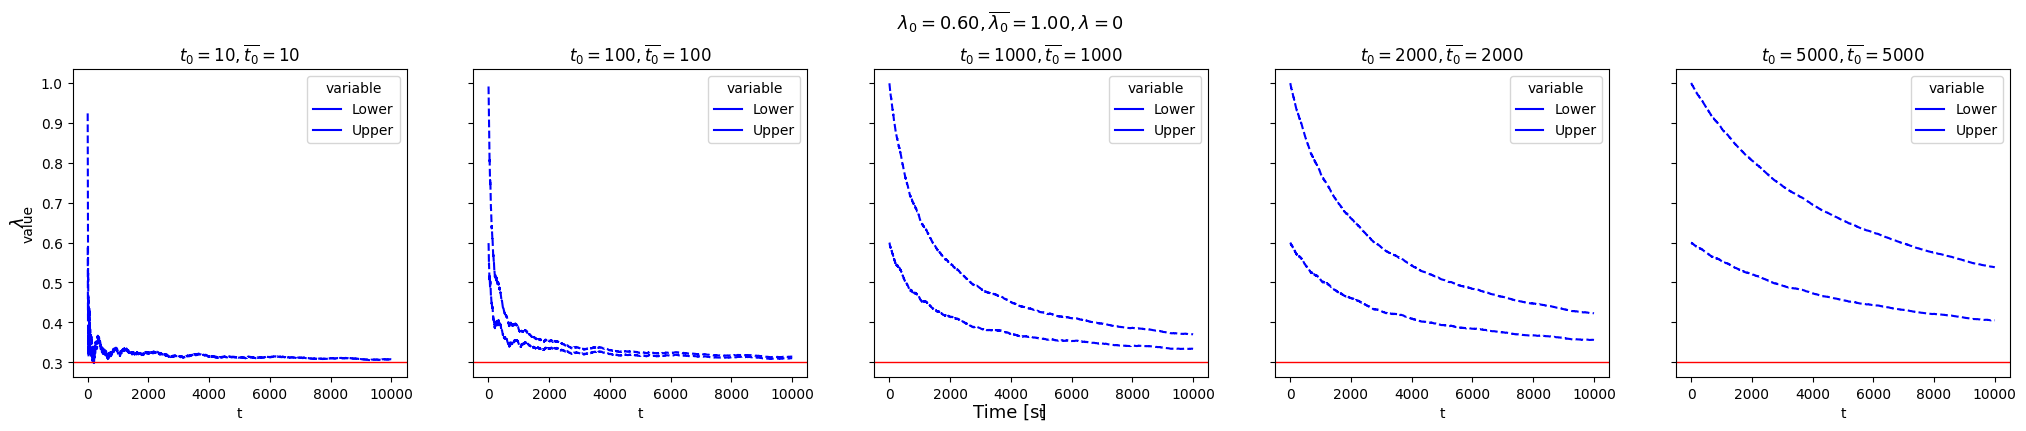

In [29]:

OPTIONS = ((10,10), (100,100), (1000,1000), (2000,2000), (5000,5000))
TMAX = 10000

r_Lower = 0.6
r_Upper = 1.0

GROUND_TRUTH = 0.3


dictDFWideDisagree610b = IPSPRunner2(OPTIONS, TMAX, r_Lower, r_Upper, GROUND_TRUTH, SEED=1)

showIPSPplot(dictDFWideDisagree610b, OPTIONS, GROUND_TRUTH, palette=['b', 'b'])


## Incorrect Wide Prior, λ=0.3,  Increasing confidence t 

n: 3070   0.307
n: 3070   0.307
n: 3070   0.307
n: 3070   0.307
n: 3070   0.307


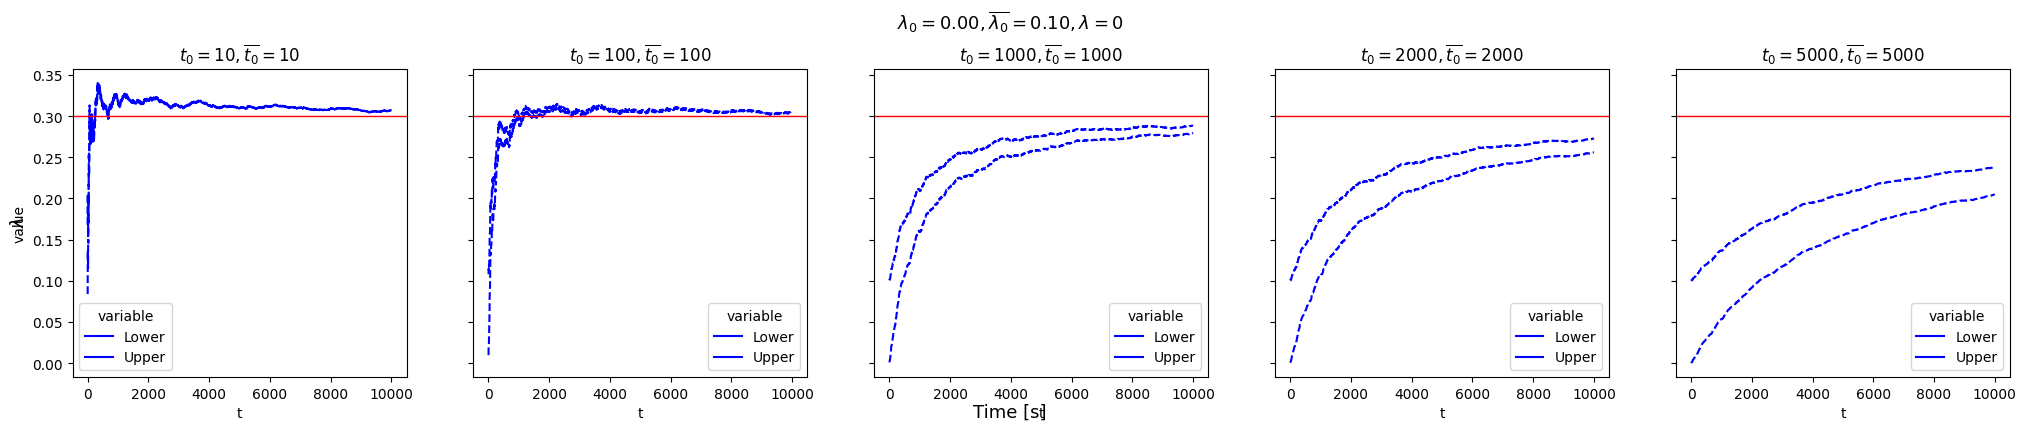

In [30]:

OPTIONS = ((10,10), (100,100), (1000,1000), (2000,2000), (5000,5000))
TMAX = 10000

r_Lower = 0.0
r_Upper = 0.1

GROUND_TRUTH = 0.3


dictDFWideDisagree01b = IPSPRunner2(OPTIONS, TMAX, r_Lower, r_Upper, GROUND_TRUTH, SEED=1)

showIPSPplot(dictDFWideDisagree01b, OPTIONS, GROUND_TRUTH, palette=['b', 'b'])


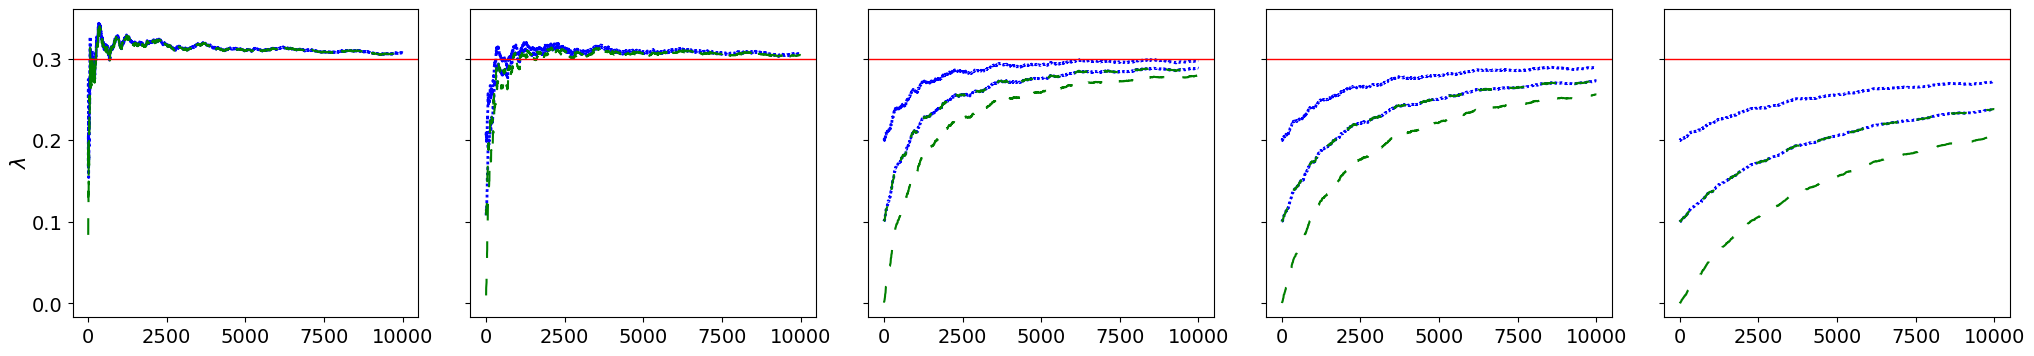

In [31]:

GROUND_TRUTH = 0.3

showIPSPplotWideNarrow(GROUND_TRUTH, OPTIONS, dictDFNarrowDisagree12b, dictDFWideDisagree01b, 'IPSPDisagree3C.pdf')


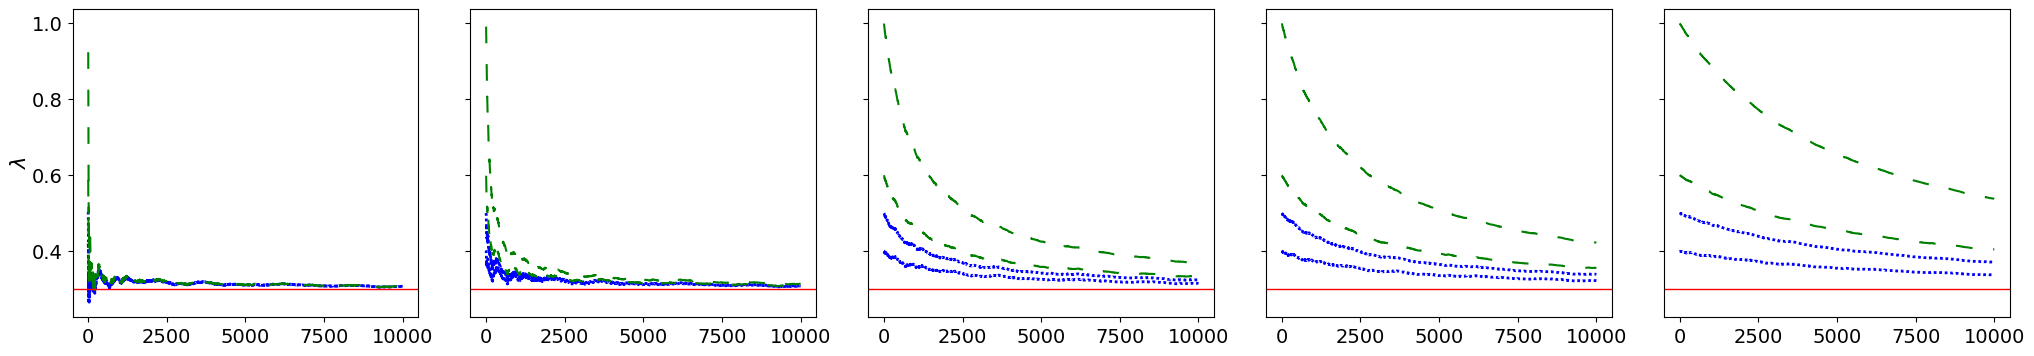

In [32]:

GROUND_TRUTH = 0.3

showIPSPplotWideNarrow(GROUND_TRUTH, OPTIONS, dictDFNarrowDisagree45b, dictDFWideDisagree610b, 'IPSPDisagree3D.pdf')

## Disagree, Wide λ, increasing confidence, Mission Time = 10^5

n: 299456   2.99456
n: 299456   2.99456
n: 299456   2.99456
n: 299456   2.99456
n: 299456   2.99456


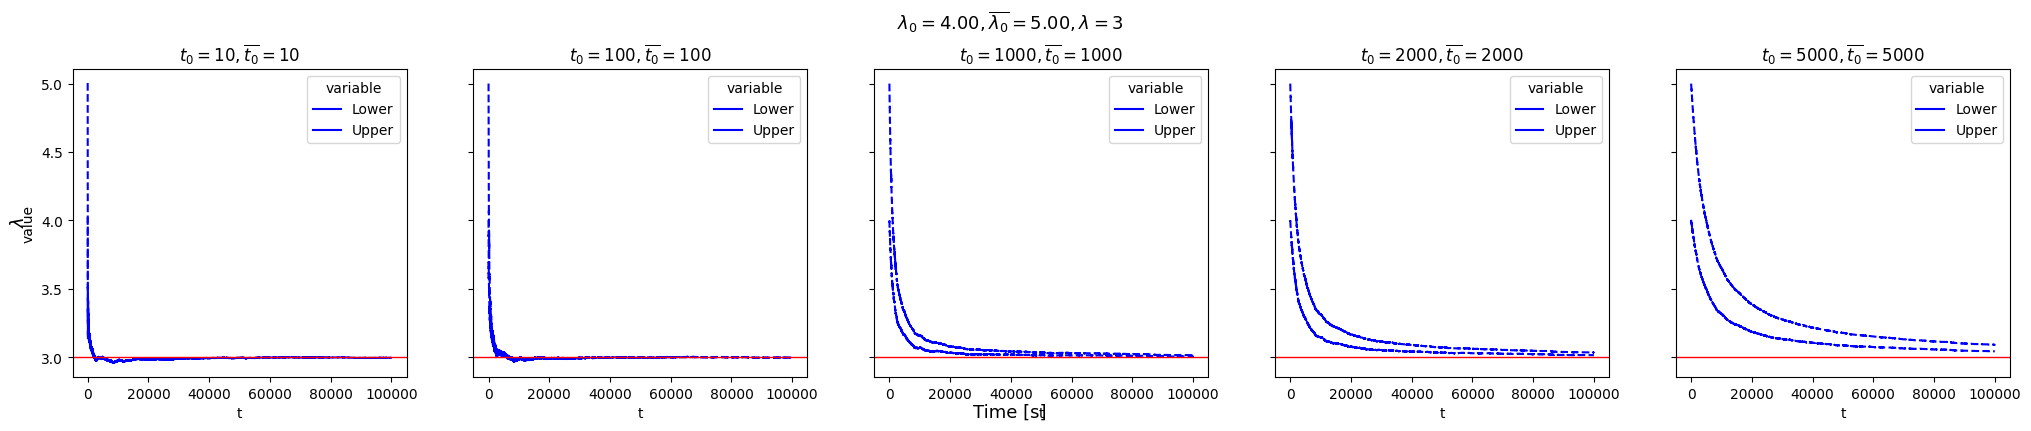

In [33]:

OPTIONS = ((10,10), (100,100), (1000,1000), (2000,2000), (5000,5000))
TMAX = 100000

r_Lower = 4
r_Upper = 5

GROUND_TRUTH = 3


dictDFNarrowDisagree45c = IPSPRunner2(OPTIONS, TMAX, r_Lower, r_Upper, GROUND_TRUTH, SEED=1)

showIPSPplot(dictDFNarrowDisagree45c, OPTIONS, GROUND_TRUTH, palette=['b', 'b'])


n: 299456   2.99456
n: 299456   2.99456
n: 299456   2.99456
n: 299456   2.99456
n: 299456   2.99456


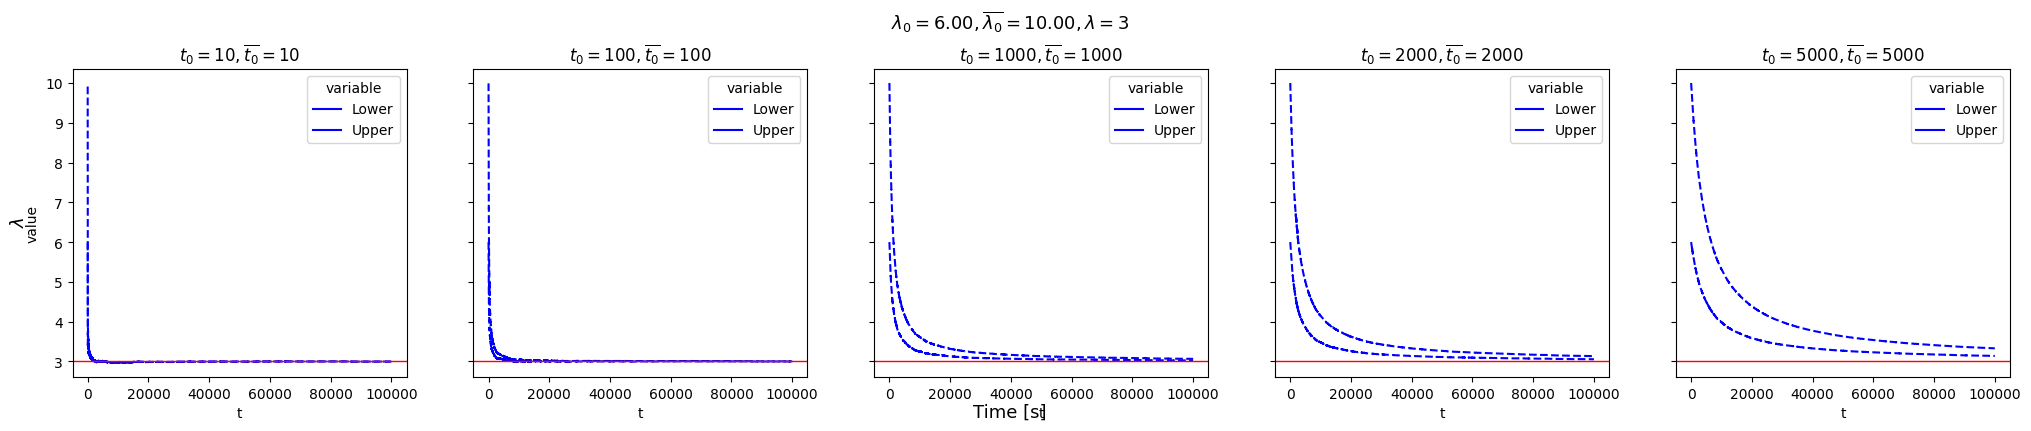

In [34]:

OPTIONS = ((10,10), (100,100), (1000,1000), (2000,2000), (5000,5000))
TMAX = 100000

r_Lower = 6
r_Upper = 10

GROUND_TRUTH = 3


dictDFNarrowDisagree610c = IPSPRunner2(OPTIONS, TMAX, r_Lower, r_Upper, GROUND_TRUTH, SEED=1)

showIPSPplot(dictDFNarrowDisagree610c, OPTIONS, GROUND_TRUTH, palette=['b', 'b'])


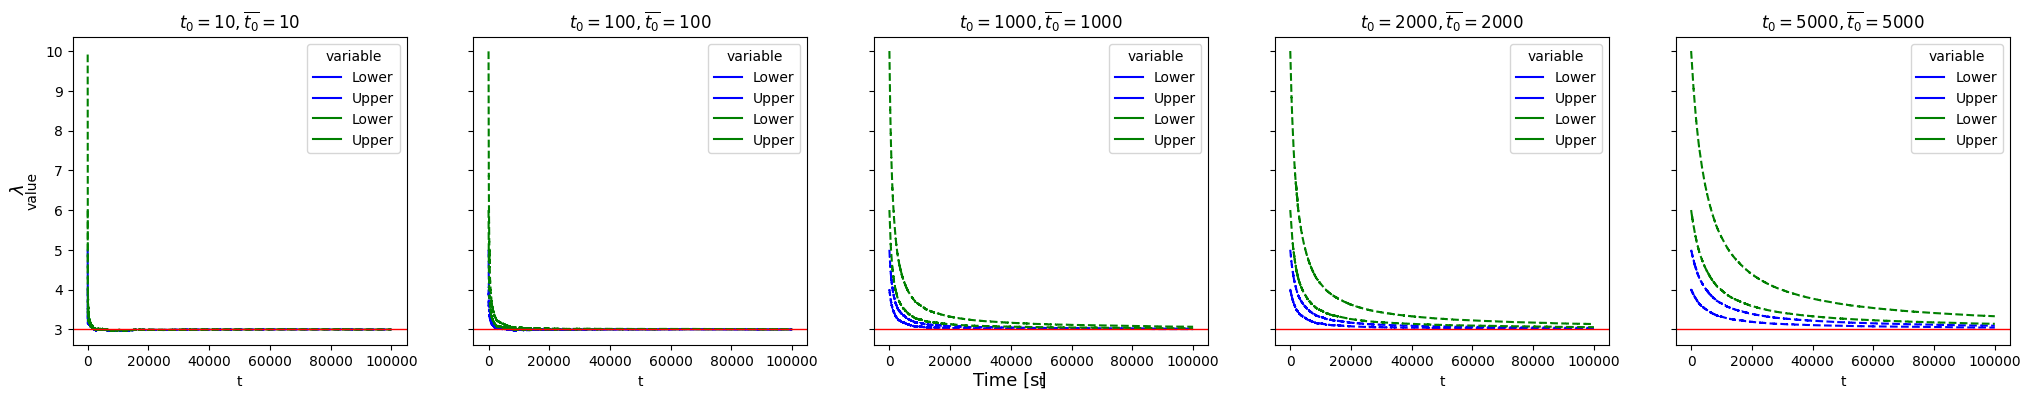

In [35]:
#Print all narrow and wide in a single graph
GROUND_TRUTH = 3

fig, axes = plt.subplots(1, len(OPTIONS), figsize=(len(OPTIONS)*5,4), sharey=True)
for i in range(0,len(OPTIONS)):
    sns.lineplot(ax=axes[i], data=pd.melt(dictDFNarrowDisagree45c[str(OPTIONS[i])], ['t']), x='t', y='value', hue='variable', palette=['blue', 'blue'], linestyle='--')#dashes=[(5, 4),(5,4)])
    sns.lineplot(ax=axes[i], data=pd.melt(dictDFNarrowDisagree610c[str(OPTIONS[i])], ['t']), x='t', y='value', hue='variable', palette=['g', 'g'], linestyle='--')#dashes=[(5, 4),(5,4)])
    axes[i].axhline(y=GROUND_TRUTH, color='red', linestyle='-', linewidth = 1)#marker='o',
    axes[i].set_title(r'$t_0=%i, \overline{t_0}=%i $' % (OPTIONS[i][0], OPTIONS[i][1]))  
    
fig.text(0.5, 0.01, 'Time [s]', ha='center', fontsize=13)
fig.text(0.1, 0.5, '$\lambda$', va='center', rotation='vertical', fontsize=13)

plt.show()

# Different $t_0$

n: 29737   2.9737
n: 29737   2.9737
n: 29737   2.9737
n: 29737   2.9737


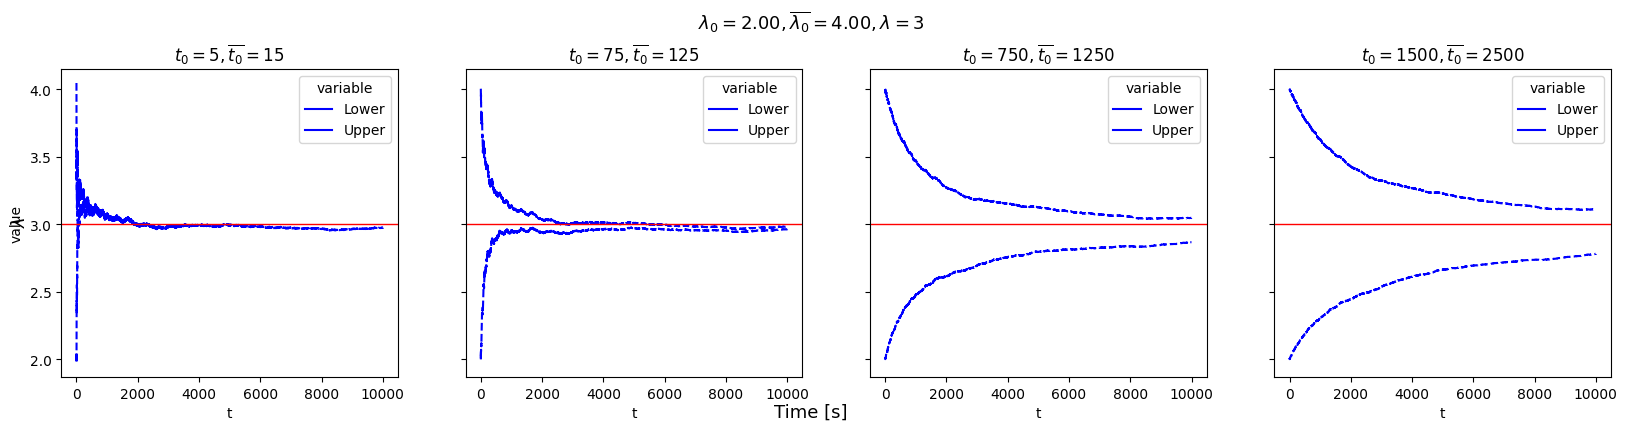

In [36]:
OPTIONS = ((5,15), (75,125), (750,1250), (1500,2500))#, (1000,3000),  (2000, 4000))

TMAX = 10000

GROUND_TRUTH = 3

r_Lower = 2
r_Upper = 4

dictDFAgreeNarrow24 = IPSPRunner2(OPTIONS, TMAX, r_Lower, r_Upper, GROUND_TRUTH, SEED=1)

showIPSPplot(dictDFAgreeNarrow24, OPTIONS, GROUND_TRUTH, palette=['b', 'b'])


n: 29737   2.9737
n: 29737   2.9737
n: 29737   2.9737
n: 29737   2.9737


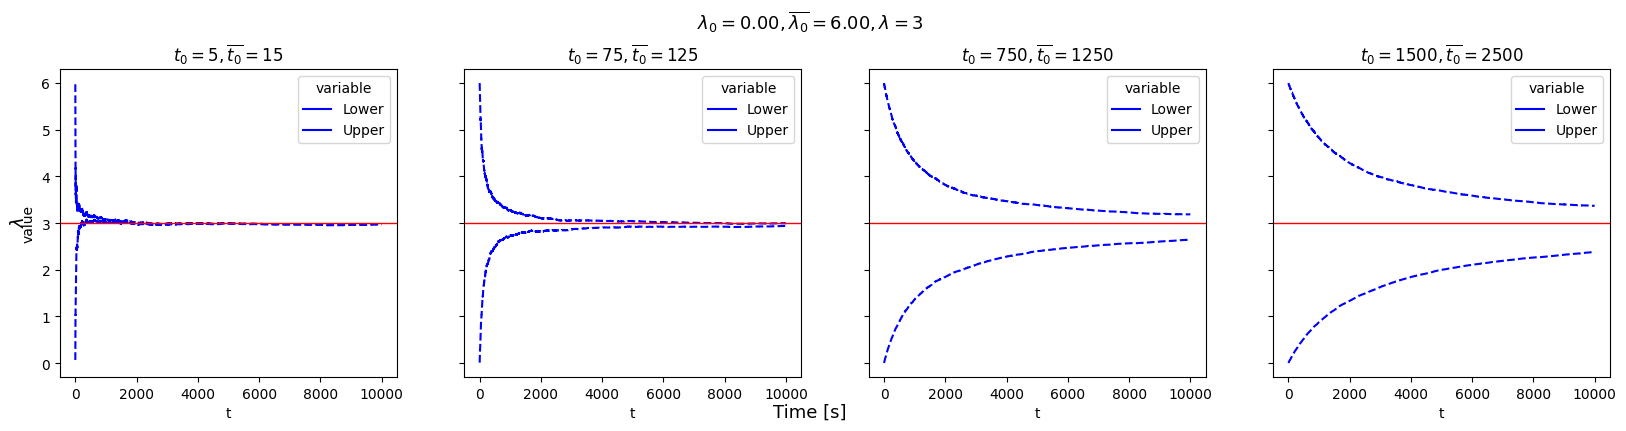

In [37]:
OPTIONS = ((5,15), (75,125), (750,1250), (1500,2500))#, (1000,3000),  (2000, 4000))

TMAX = 10000

GROUND_TRUTH = 3

r_Lower = 0
r_Upper = 6


dictDFAgreeWide06 = IPSPRunner2(OPTIONS, TMAX, r_Lower, r_Upper, GROUND_TRUTH, SEED=1)

showIPSPplot(dictDFAgreeWide06, OPTIONS, GROUND_TRUTH, palette=['b', 'b'])


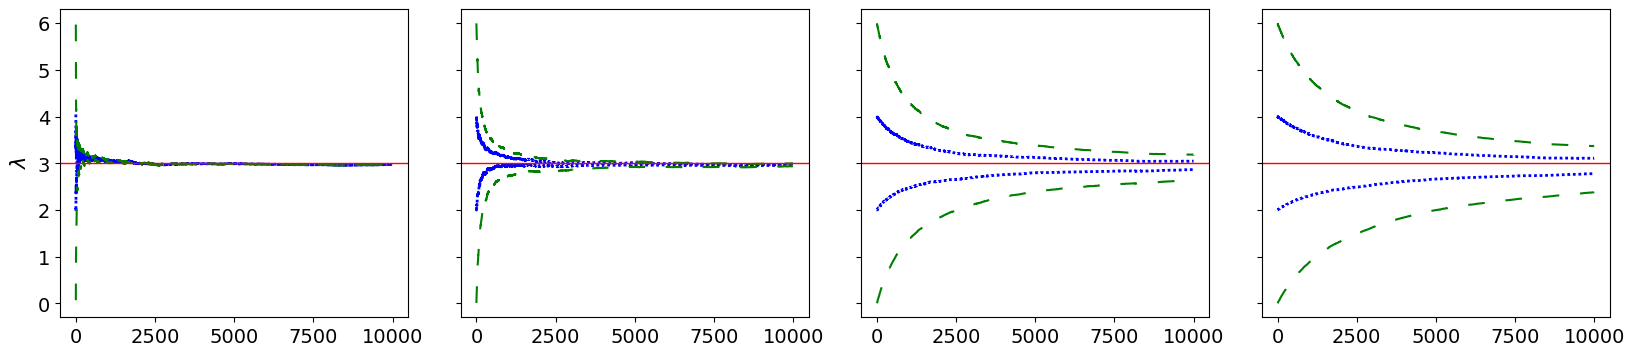

In [38]:

GROUND_TRUTH = 3

showIPSPplotWideNarrow(GROUND_TRUTH, OPTIONS, dictDFAgreeNarrow24, dictDFAgreeWide06, 'IPSPCorrect3VaryingT1.pdf')

n: 29737   2.9737
n: 29737   2.9737
n: 29737   2.9737
n: 29737   2.9737


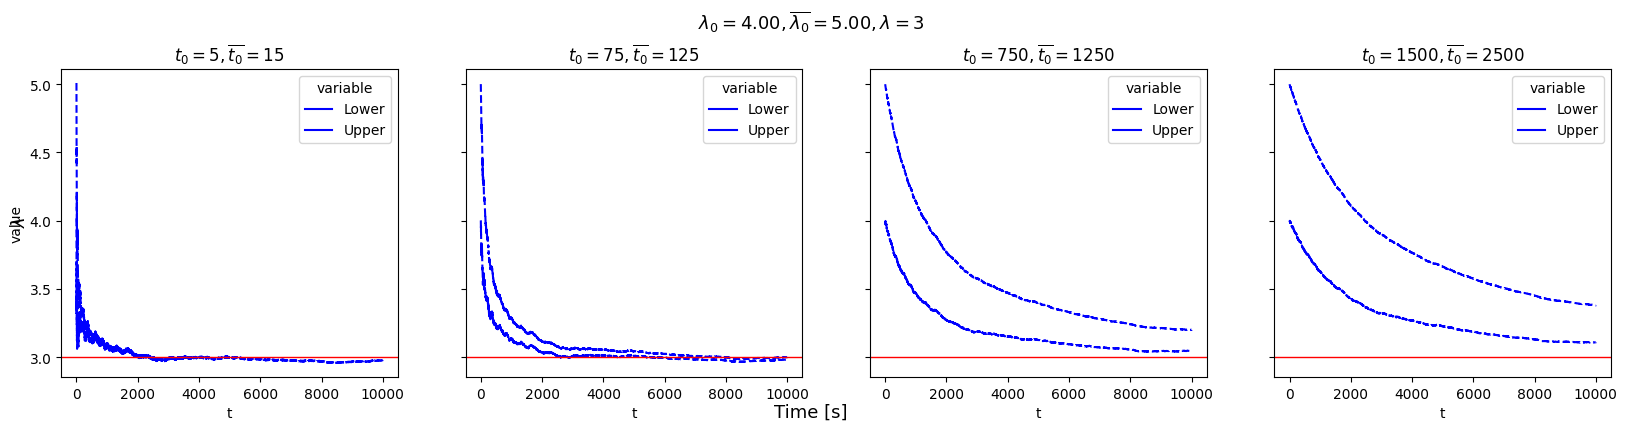

In [39]:

OPTIONS = ((5,15), (75,125), (750,1250), (1500,2500))#, (1000,3000),  (2000, 4000))

TMAX = 10000

GROUND_TRUTH = 3

r_Lower = 4
r_Upper = 5


dictDFDisAgreeNarrow45 = IPSPRunner2(OPTIONS, TMAX, r_Lower, r_Upper, GROUND_TRUTH, SEED=1)

showIPSPplot(dictDFDisAgreeNarrow45, OPTIONS, GROUND_TRUTH, palette=['b', 'b'])


n: 29737   2.9737
n: 29737   2.9737
n: 29737   2.9737
n: 29737   2.9737


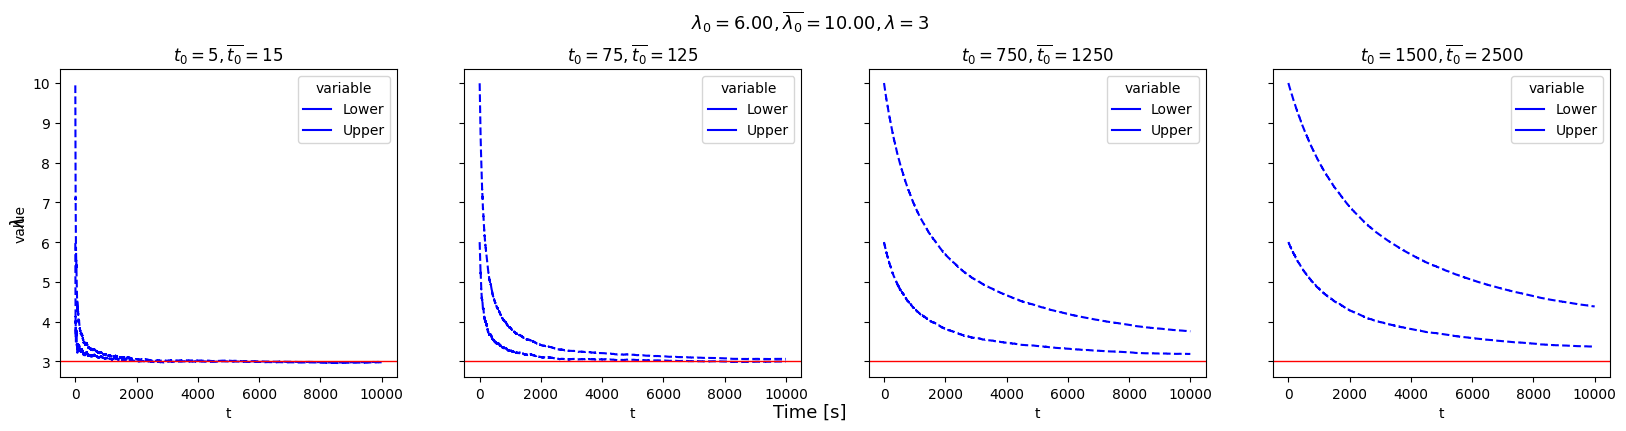

In [40]:

OPTIONS = ((5,15), (75,125), (750,1250), (1500,2500))#, (1000,3000),  (2000, 4000))

TMAX = 10000

GROUND_TRUTH = 3

r_Lower = 6
r_Upper = 10


dictDFDisAgreeWide610 = IPSPRunner2(OPTIONS, TMAX, r_Lower, r_Upper, GROUND_TRUTH, SEED=1)

showIPSPplot(dictDFDisAgreeWide610, OPTIONS, GROUND_TRUTH, palette=['b', 'b'])


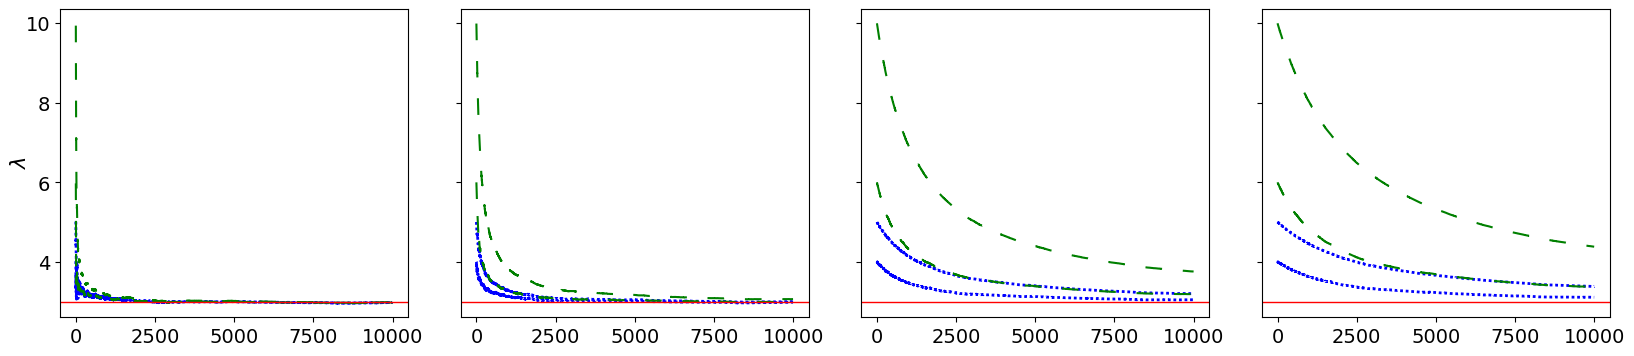

In [41]:

GROUND_TRUTH = 3

showIPSPplotWideNarrow(GROUND_TRUTH, OPTIONS, dictDFDisAgreeNarrow45, dictDFDisAgreeWide610, 'IPSPCorrect3VaryingT1B.pdf')

n: 29737   2.9737
n: 29737   2.9737
n: 29737   2.9737
n: 29737   2.9737


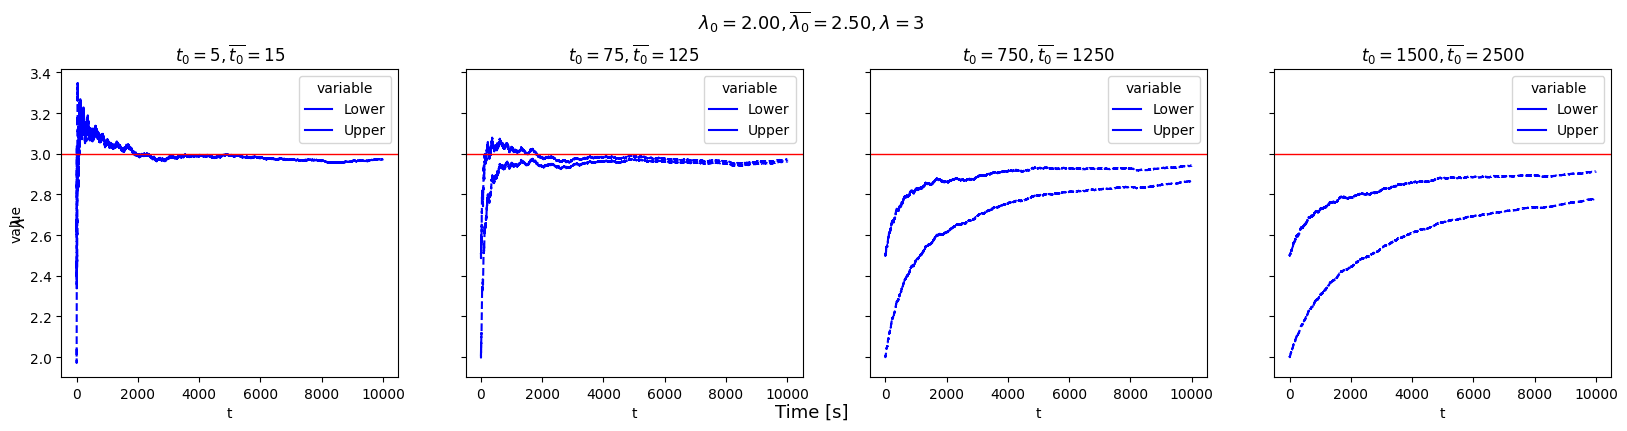

In [42]:

OPTIONS = ((5,15), (75,125), (750,1250), (1500,2500))#, (1000,3000),  (2000, 4000))

TMAX = 10000

GROUND_TRUTH = 3

r_Lower = 2
r_Upper = 2.5


dictDFDisAgreeNarrow225 = IPSPRunner2(OPTIONS, TMAX, r_Lower, r_Upper, GROUND_TRUTH, SEED=1)

showIPSPplot(dictDFDisAgreeNarrow225, OPTIONS, GROUND_TRUTH, palette=['b', 'b'])


n: 29737   2.9737
n: 29737   2.9737
n: 29737   2.9737
n: 29737   2.9737


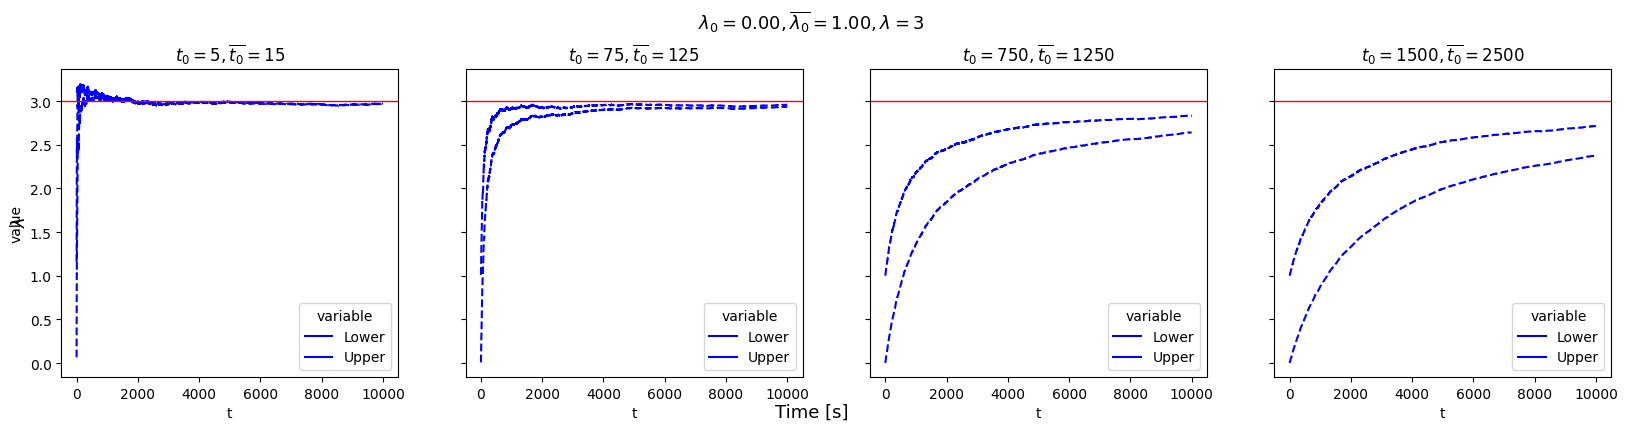

In [43]:

OPTIONS = ((5,15), (75,125), (750,1250), (1500,2500))#, (1000,3000),  (2000, 4000))

TMAX = 10000

GROUND_TRUTH = 3

r_Lower = 0
r_Upper = 1


dictDFDisAgreeWide01 = IPSPRunner2(OPTIONS, TMAX, r_Lower, r_Upper, GROUND_TRUTH, SEED=1)

showIPSPplot(dictDFDisAgreeWide01, OPTIONS, GROUND_TRUTH, palette=['b', 'b'])


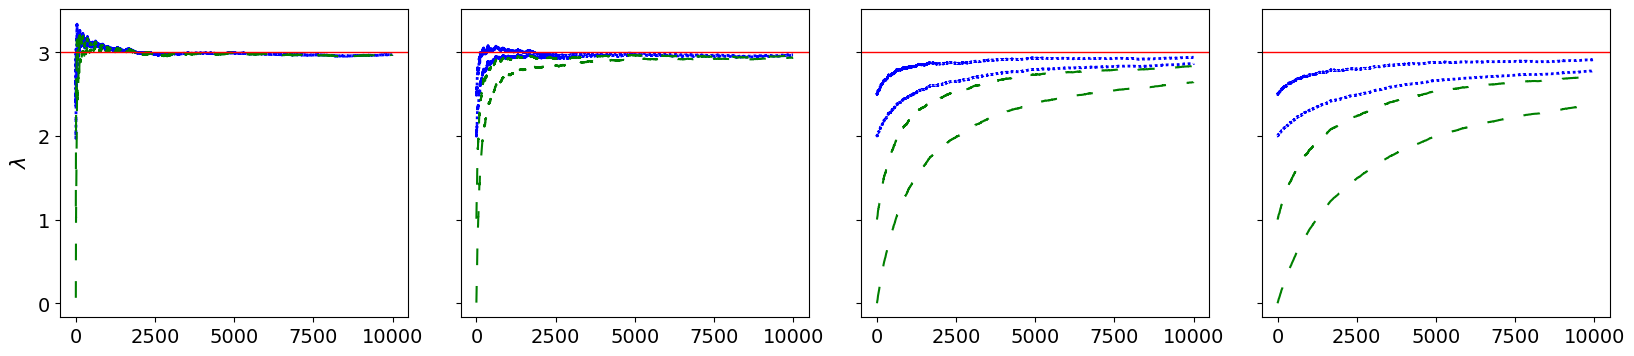

In [44]:

GROUND_TRUTH = 3

showIPSPplotWideNarrow(GROUND_TRUTH, OPTIONS, dictDFDisAgreeNarrow225, dictDFDisAgreeWide01, 'IPSPCorrect3VaryingT1C.pdf')

----
----
----
----


# BIPP

**Notes**

* $\epsilon_0=0, \epsilon_3=\infty$
* when $m=3 \Rightarrow   [\epsilon_0, \epsilon_1]:\theta_1; (\epsilon_1,\epsilon_2]:\theta_2; (\epsilon_2,\epsilon_3):1-\theta_1-\theta_2$
* when $m=2 \bullet \epsilon_1=\epsilon_2 \land \theta_2=0 \Rightarrow [\epsilon_0, \epsilon_1]:\theta_1; (\epsilon_1,\epsilon_1]:0; (\epsilon_1,\epsilon_3):1-\theta_1$

In [45]:
#Import math Library
import math 
import pandas as pd

class  BIPP:
  def __init__(self, epsilon1, theta1, epsilon2, theta2):
    self.e1     = epsilon1
    self.th1    = theta1
    self.e2     = epsilon2
    self.th2    = theta2


  def l(self, x, t):
    return math.exp(-x * t)


  def execute (self, t):
    if(self.th2*(self.e1-self.e2)*self.l(self.e1, t)*self.l(self.e2, t)+self.th1*self.e1*self.l(self.e1, t)-self.th1*self.e2*self.l(self.e2, t)>=0):
      self.r_lower = (self.e1*self.l(self.e1, t)*self.th2)/(self.th1+self.l(self.e1, t)*self.th2)
    else:
      self.r_lower = (self.e2*self.l(self.e2, t)*self.th2)/(self.th1+self.l(self.e2, t)*self.th2)

    
    if (t<1/self.e2):
      self.r_upper = (self.e1*self.l(self.e1, t)*self.th1 + self.e2*self.l(self.e2, t)*self.th2 + (1/t)*self.l(1/t, t)*(1-self.th1-self.th2)) / (self.l(self.e1, t)*self.th1)
    elif ( (1/self.e2<=t) and (t<=1/self.e1)):
      self.r_upper = (self.e1*self.l(self.e1, t)*self.th1 + (1/t)*self.l(1/t, t)*self.th2 + self.e2*self.l(self.e2, t)*(1-self.th1-self.th2)) / (self.l(self.e1, t)*self.th1)
    else:
      self.r_upper = (self.e1*self.l(self.e1, t)*(self.th1+self.th2) + (self.e2)*self.l(self.e2, t)*(1-self.th1-self.th2)) / (self.l(self.e1, t)*self.th1)

    
    return (self.r_lower, self.r_upper)
  


In [46]:
def plotBIPP(OPTIONS, dictDF, ylim=0.0008):
    fig, axes = plt.subplots(1, len(OPTIONS), figsize=(len(OPTIONS)*5,4))#, sharey=True)
    # fig.suptitle(r'$t_0=%i, \overline{t_0}=%i,  \lambda_0=%.2f, \overline{\lambda_0}=%.2f$' %(t_Lower,t_Upper,r_Lower,r_Upper), fontsize=13, y=1.03)

    for i in range(0,len(OPTIONS)):
        ax = sns.lineplot(ax=axes[i], data=dictDF[str(OPTIONS[i])],  palette=['black', 'black'])
        axes[i].set_title(r'$\epsilon_1=%.6f, \theta_1=%.1f, \epsilon_2=%.6f, \theta_2=%.1f$' \
                          % (OPTIONS[i][0], OPTIONS[i][1], OPTIONS[i][2], OPTIONS[i][3]))
        axes[i].set_ylim([-0.00001, ylim])
        
#         print(ax.get_legend())
        ax.legend(['$\lambda_l$', '$\lambda_u$'])
        

    fig.text(0.5, 0.01, 'Time [s]', ha='center', fontsize=13)
    fig.text(0.1, 0.5, '$\lambda$', va='center', rotation='vertical', fontsize=13)
    
    

    plt.show()
    
    

def BIPPRunner(OPTIONS, TMAX):
    dictDF = {}

    for o in OPTIONS:
        epsilon1  = o[0]
        theta1    = o[1]
        epsilon2  = o[2]
        theta2    = o[3]

        bipp = BIPP(epsilon1, theta1, epsilon2, theta2)
        bipp_lower = []
        bipp_upper = []

        for t in range(1,TMAX):
            v = bipp.execute(t)
            bipp_lower.append(v[0])
            bipp_upper.append(v[1])

        df = pd.DataFrame(list(zip(bipp_lower, bipp_upper)), columns=['Lower', 'Upper'])
        dictDF[str(o)] = df
    
    return dictDF

## Increasing $\theta_2 \in \{0.1, 0.3, 0.6, 0.9\}, \epsilon_1=10^-5, \epsilon_2=10^-4$

* fixed $\theta_1=0.1$

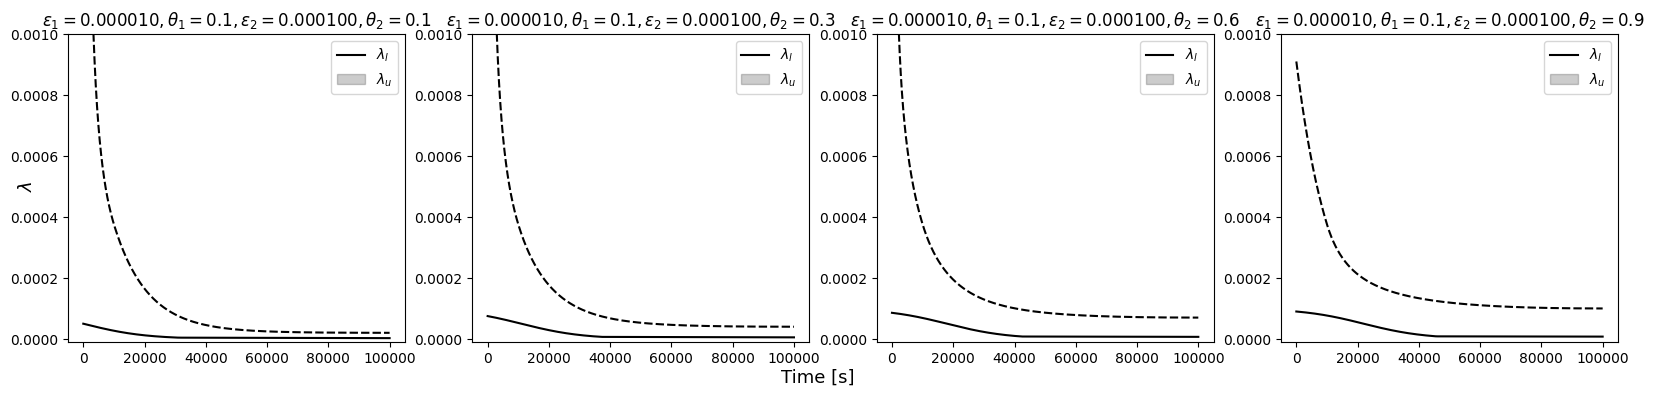

In [47]:
TMAX = 100000

OPTIONS = ((1/100000, 0.1, 1/10000, 0.1), (1/100000, 0.1, 1/10000, 0.3), 
           (1/100000, 0.1, 1/10000, 0.6), (1/100000, 0.1, 1/10000, 0.9))


dictDF = BIPPRunner(OPTIONS, TMAX)

plotBIPP(OPTIONS, dictDF, ylim=0.001)

## Increasing $\theta_1 \in \{0.1, 0.3, 0.6, 0.9\}, \epsilon_1=10^-5, \epsilon_2=10^-4$

* fixed $\theta_2=0.1$

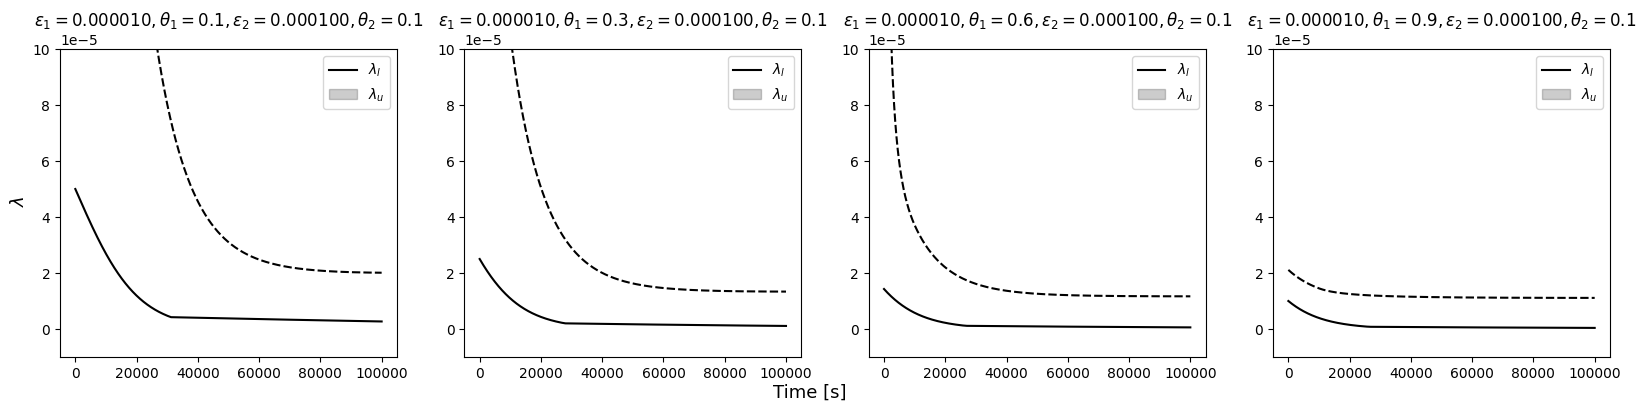

In [48]:
TMAX = 100000

OPTIONS = ((1/100000, 0.1, 1/10000, 0.1), (1/100000, 0.3, 1/10000, 0.1), 
           (1/100000, 0.6, 1/10000, 0.1), (1/100000, 0.9, 1/10000, 0.1))


dictDF = BIPPRunner(OPTIONS, TMAX)

plotBIPP(OPTIONS, dictDF, ylim=0.0001)

## Same $\theta_1 = \theta_2 \in \{0.1, 0.4, 0.5\}, \epsilon_1=10^-4, \epsilon_2=10^-3$

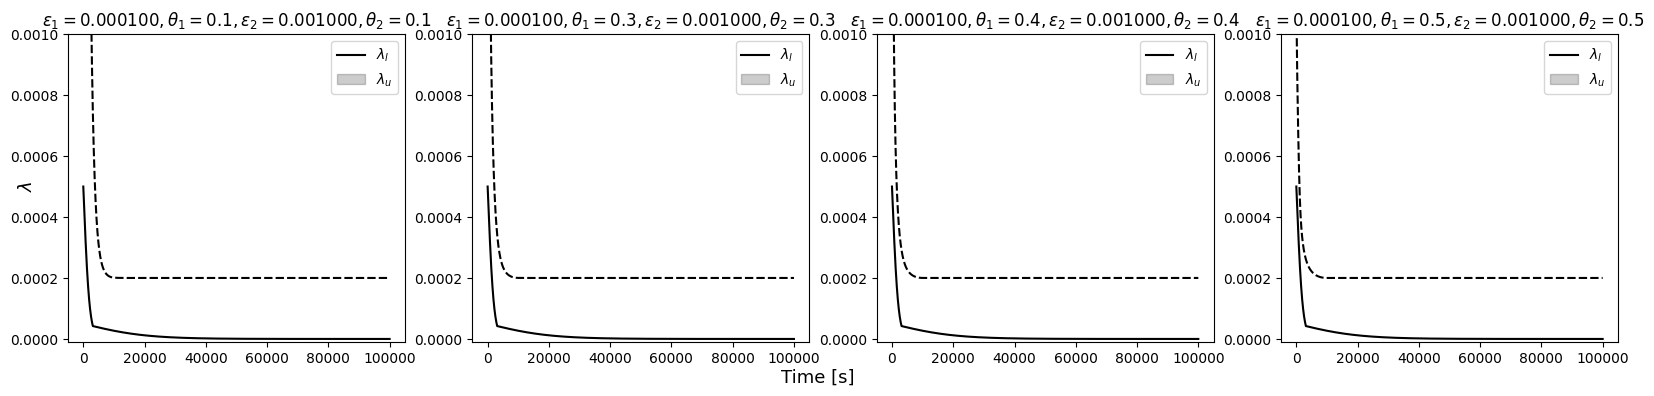

In [49]:
TMAX = 100000

OPTIONS = ((1/10000, 0.1, 1/1000, 0.1), (1/10000, 0.3, 1/1000, 0.3), 
           (1/10000, 0.4, 1/1000, 0.4), (1/10000, 0.5, 1/1000, 0.5))

OPTIONSe1 = OPTIONS
dictDFe1 = BIPPRunner(OPTIONS, TMAX)

plotBIPP(OPTIONS, dictDFe1, ylim=0.001)

## Same $\theta_1 = \theta_2 \in \{0.1, 0.4, 0.5\}, \epsilon_1=10^-5, \epsilon_2=10^-4$

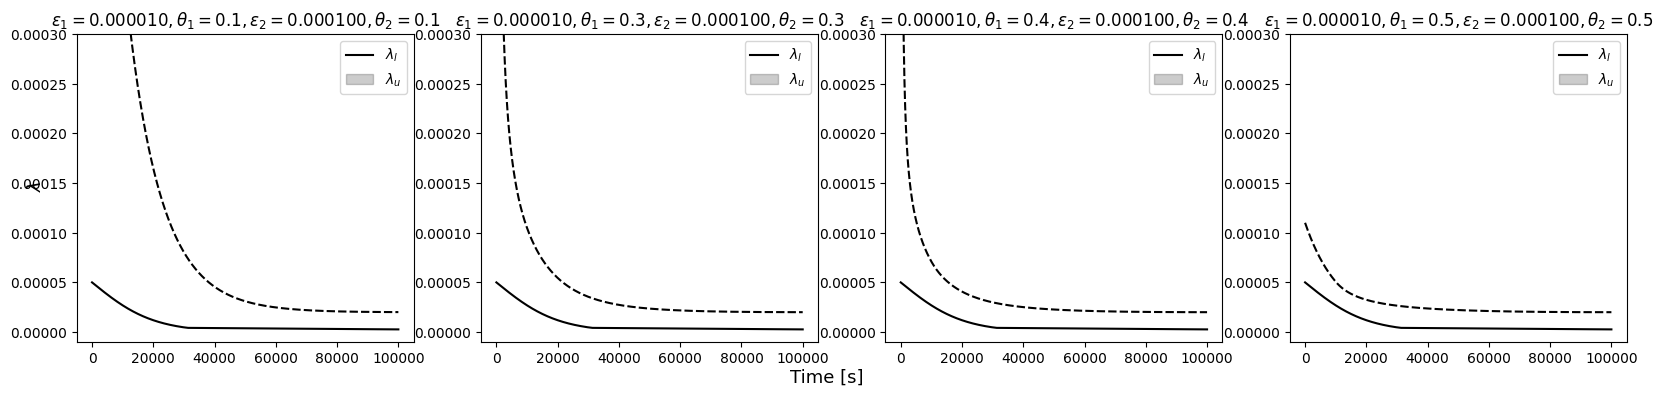

In [50]:
TMAX = 100000

OPTIONS = ((1/100000, 0.1, 1/10000, 0.1), (1/100000, 0.3, 1/10000, 0.3), 
           (1/100000, 0.4, 1/10000, 0.4), (1/100000, 0.5, 1/10000, 0.5))

OPTIONSe2 = OPTIONS
dictDFe2 = BIPPRunner(OPTIONS, TMAX)

plotBIPP(OPTIONS, dictDFe2, ylim=0.0003)

## Same $\theta_1 = \theta_2 \in \{0.1, 0.4, 0.5\}, \epsilon_1=10^-6, \epsilon_2=10^-5$

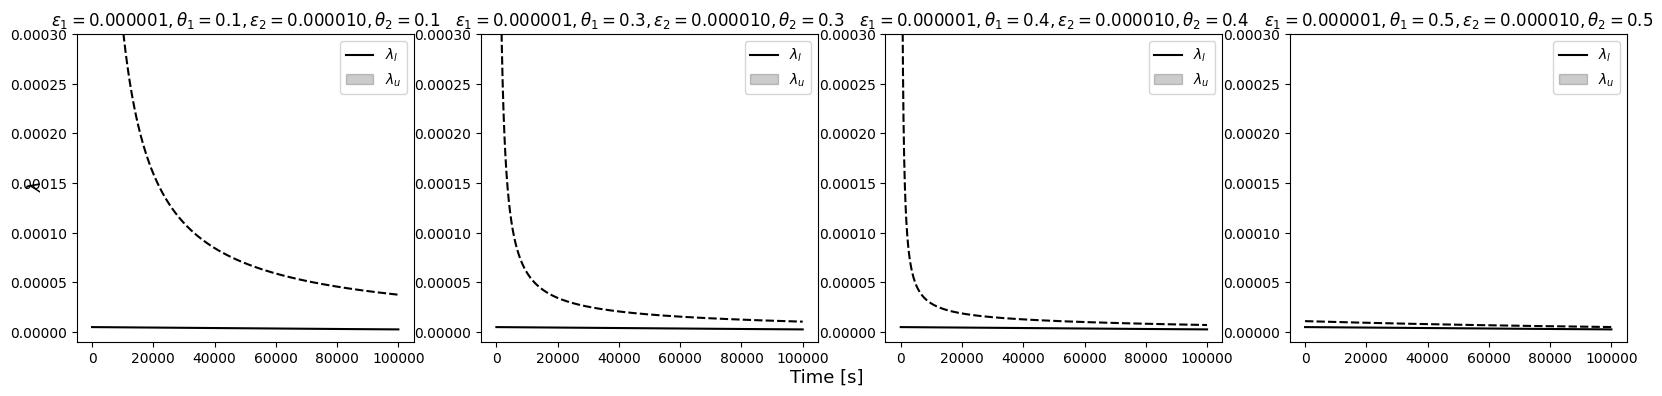

In [51]:
TMAX = 100000

OPTIONS = ((1/1000000, 0.1, 1/100000, 0.1), (1/1000000, 0.3, 1/100000, 0.3), 
           (1/1000000, 0.4, 1/100000, 0.4), (1/1000000, 0.5, 1/100000, 0.5))

OPTIONSe3 = OPTIONS
dictDFe3 = BIPPRunner(OPTIONS, TMAX)

plotBIPP(OPTIONS, dictDFe3, ylim=0.0003)

## Same $\theta_1 = \theta_2 \in \{0.1, 0.4, 0.5\}, \epsilon_1=10^-7, \epsilon_2=10^-6$

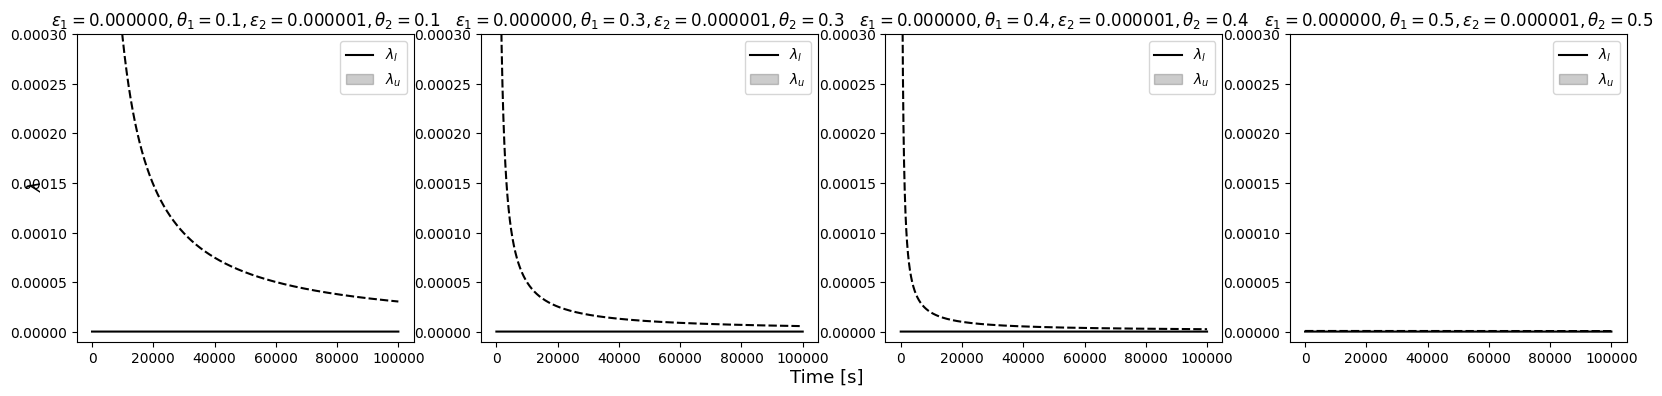

In [52]:
TMAX = 100000

OPTIONS = ((10**-7, 0.1, 10**-6, 0.1), (10**-7, 0.3, 10**-6, 0.3), 
           (10**-7, 0.4, 10**-6, 0.4), (10**-7, 0.5, 10**-6, 0.5))

OPTIONSe3 = OPTIONS
dictDFe3 = BIPPRunner(OPTIONS, TMAX)

plotBIPP(OPTIONS, dictDFe3, ylim=0.0003)

## Same $\theta_2 =0, \epsilon_1=\epsilon_2$

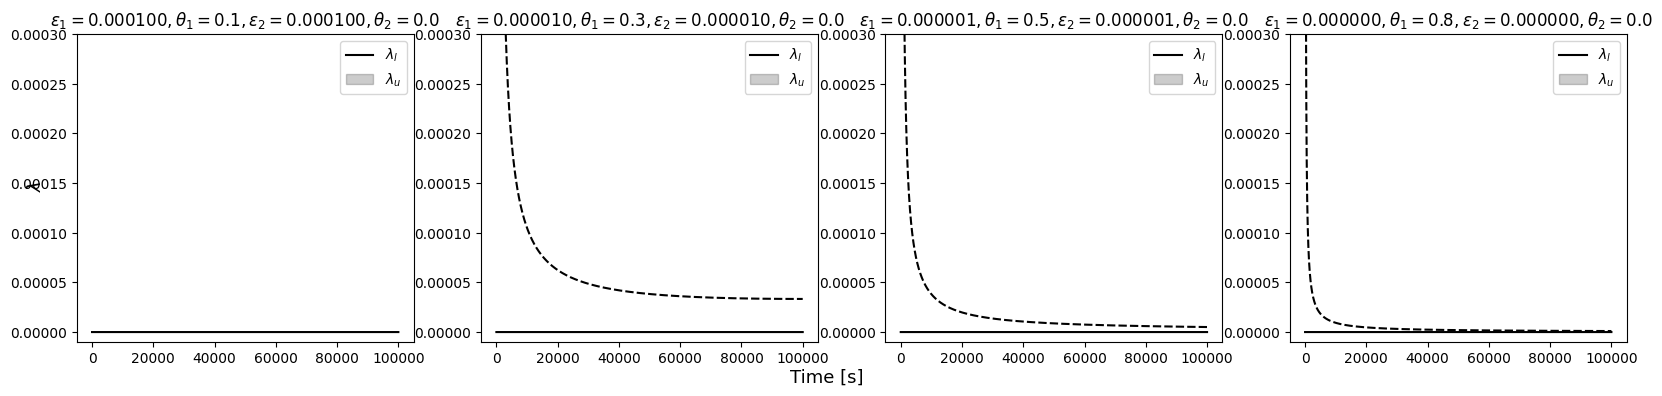

In [53]:
TMAX = 100000

OPTIONS = ((10**-4, 0.1, 10**-4, 0.0), (10**-5, 0.3, 10**-5, 0.0), 
           (10**-6, 0.5, 10**-6, 0.0), (10**-7, 0.8, 10**-7, 0.0))

OPTIONSe3 = OPTIONS
dictDFe4 = BIPPRunner(OPTIONS, TMAX)

plotBIPP(OPTIONS, dictDFe4, ylim=0.0003)

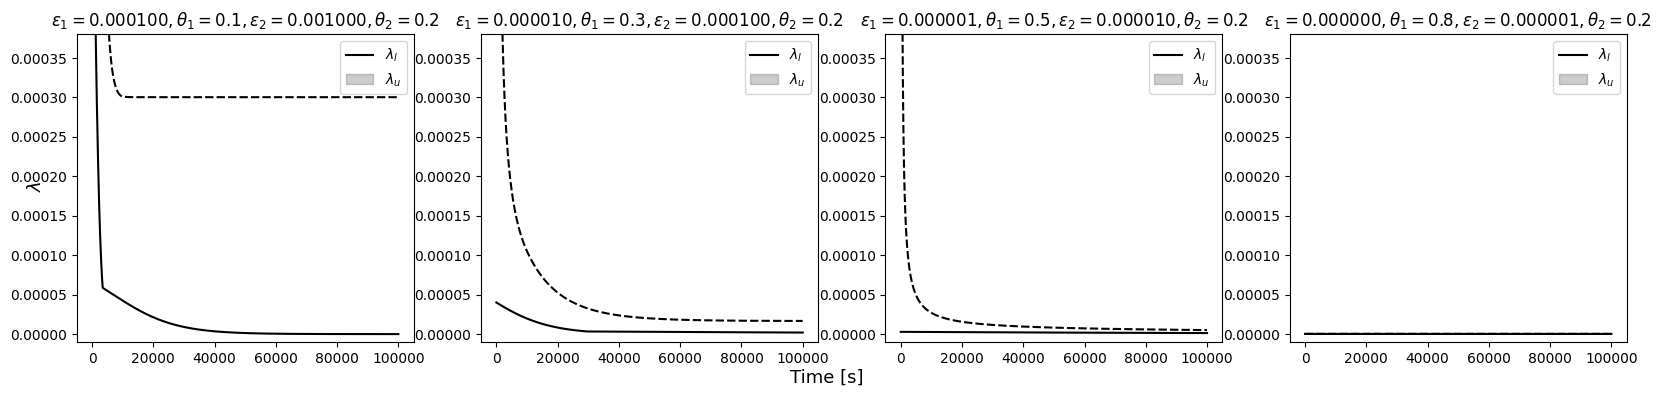

In [54]:
TMAX = 100000

OPTIONS = ((10**-4, 0.1, 10**-3, 0.2), (10**-5, 0.3, 10**-4, 0.2), 
           (10**-6, 0.5, 10**-5, 0.2), (10**-7, 0.8, 10**-6, 0.2))

OPTIONSe3 = OPTIONS
dictDFe4 = BIPPRunner(OPTIONS, TMAX)

plotBIPP(OPTIONS, dictDFe4, ylim=0.00038)

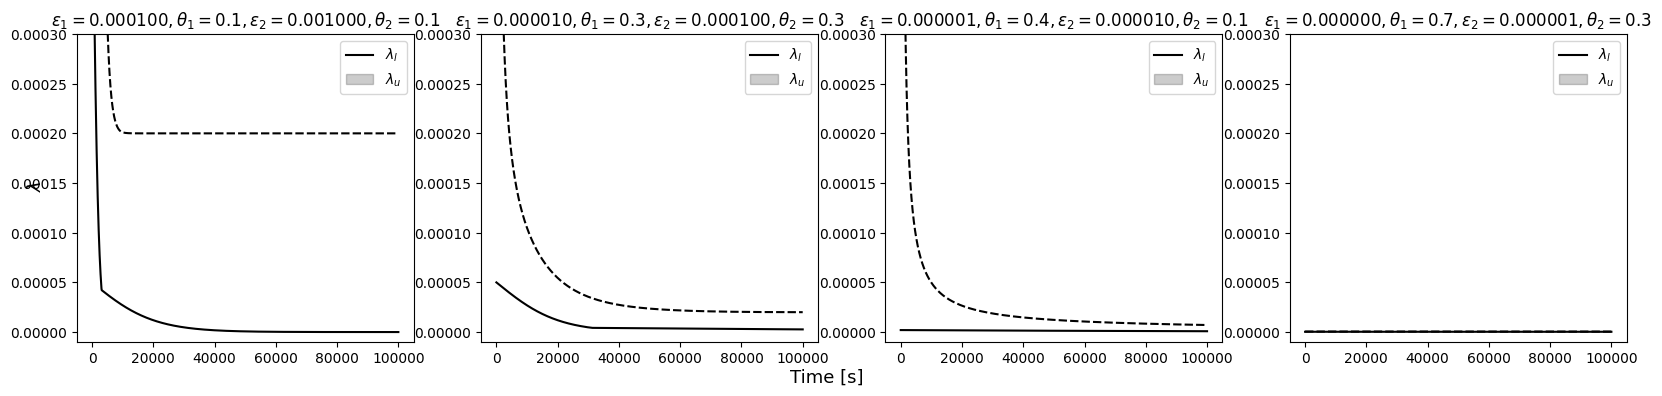

In [55]:
TMAX = 100000

OPTIONS = ((10**-4, 0.1, 10**-3, 0.1), (10**-5, 0.3, 10**-4, 0.3), 
           (10**-6, 0.4, 10**-5, 0.1), (10**-7, 0.7, 10**-6, 0.3))

OPTIONSe3 = OPTIONS
dictDFe4 = BIPPRunner(OPTIONS, TMAX)

plotBIPP(OPTIONS, dictDFe4, ylim=0.0003)

## Same $\theta_1 = \theta_2 \in \{0.1, 0.4, 0.5\}, \epsilon_1=10^-6, \epsilon_2=10^-3$

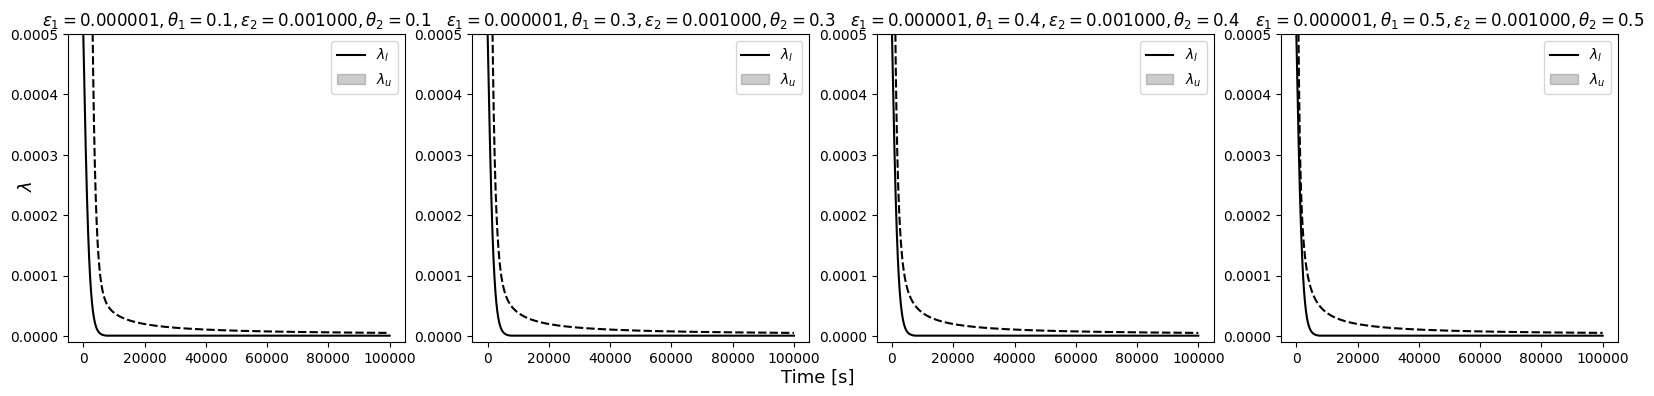

In [57]:
TMAX = 100000

OPTIONS = ((1/1000000, 0.1, 1/1000, 0.1), (1/1000000, 0.3, 1/1000, 0.3), 
           (1/1000000, 0.4, 1/1000, 0.4), (1/1000000, 0.5, 1/1000, 0.5))


dictDF = BIPPRunner(OPTIONS, TMAX)

plotBIPP(OPTIONS, dictDF, ylim=0.0005)

---
---
---